### plotting with seaborn
only use under analysis environment 

Basically everthing that needed to read/modify/write excel and plotting with sns

June update:
added section for generating excel files for averaged brains based on individual sample's excel

June 23 update:

    heatmaps:
    only include regions belonging to cerebrum, brain stem and cerebellum
    Include a threshold of 0.001 (0.1%) -> this threshold is not applied to isocortex only plot

July 03 update:
    
    bar graphs:
    depth 2 and depth 4
    isocortex only- item values normalized to total isocortex values
    MO regions only - item values normalized to total MO region values

In [1]:
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/','/512/']
    cc_cb_bs= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 and cerebellum  512 region only 
      
    new= cc_cb_bs.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_old(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    new= specific_df.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

### Generate excel files for averaged brains based on excel file of each sample
with standard deviations

In [4]:
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [5]:
def average_excel(name_list, side, output_name):
    parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
    #change side to right for the other hemisphere!
    
    file_list=[]
    for i in name_list:
        contained = [x for x in parent_axons if i in x]
        file_list.append(contained[0])
    # extract all the file containing thesample name
    
    print('now processing the following files:')
    print(f'{file_list}')
    
    out_name=os.path.join(outdir,output_name)
    
    axonal_df= combine_df(folder, file_list)
    axonal_df=axonal_df.T
    
    y=axonal_df.index.to_list()
    test_order=[]

    for i in y:
        name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
        test_order.append(name)

    sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
    sort_acronym_df.sort_values('graph_order', inplace=True)
    # sort the aconnyms based on graph order

    final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
    #final_df
    
    final_df['average']=final_df.mean(axis=1)
    final_df['std']= final_df.std(axis=1)
    # compute average and std
    
    result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
    # need to reset_index here because acronym was both an index and a column
    
    result.to_excel(f'{out_name}_avg_{side}.xlsx') 
    
    return 


#### for s1 sim1 samples

In [29]:
region='s1'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL207','AL209','AL273']

##### left side - detialed code

In [24]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
#change side to right for the other hemisphere!

#name_list= ['AL207','AL209','AL273']

file_list=[]
for i in name_list:
    contained = [x for x in parent_axons if i in x]
    file_list.append(contained[0])
# extract all the file containing thesample name

file_list

out_name=os.path.join(outdir,'s1_sim')

In [8]:
axonal_df= combine_df(folder, file_list)
axonal_df=axonal_df.T

axonal_df.head()

# combine values from relevant samples based on acronym

,AL207,AL209,AL273
acronym,,,
fiber tracts,0.005841,0.001936,0.00355
RT,0.019293,0.00478,0.005749
VISal1,0.001994,0.000344,0.000134
ll,0.000155,0.000083,0.000156
MD,0.000292,0.00026,0.000875


In [9]:
y=axonal_df.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)
    
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on graph order

final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

In [15]:
final_df['average']=final_df.mean(axis=1)
final_df['std']= final_df.std(axis=1)
# compute average and std

In [18]:
result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
# need to reset_index here because acronym was both an index and a column
result.head()

# final result keeps all individual values but also computed average and std

,acronym,AL207,AL209,AL273,average,std,id,atlas_id,name,st_level,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,root,0.000642,0.000836,0.003453,0.001644,0.001282,997,-1.0,root,0,...,0,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root
1,FRP2/3,NaN,NaN,0.000004,0.000004,0.000000,667,1073.0,"Frontal pole, layer 2/3",11,...,8,/997/8/567/688/695/315/184/667/,268F45,NaN,NaN,f,9,4268100038,734881840,Frontal pole layer 2/3
2,FRP5,NaN,NaN,0.000075,0.000075,0.000000,526157192,NaN,"Frontal pole, layer 5",11,...,9,/997/8/567/688/695/315/184/526157192/,268F45,NaN,NaN,f,10,1413248090,734881840,Frontal pole layer 5
3,MOp1,0.000872,0.000001,0.001212,0.000695,0.000510,320,888.0,"Primary motor area, Layer 1",11,...,19,/997/8/567/688/695/315/500/985/320/,1F9D5A,NaN,NaN,f,20,571569106,734881840,Primary motor area Layer 1
4,MOp2/3,0.002361,0.000201,0.002009,0.001524,0.000946,943,966.0,"Primary motor area, Layer 2/3",11,...,20,/997/8/567/688/695/315/500/985/943/,1F9D5A,NaN,NaN,f,21,2488357079,734881840,Primary motor area Layer 2/3


In [19]:
result.to_excel(f'{out_name}_avg_{side}.xlsx') 
# save

##### right side 

In [38]:
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL207_axon_right_region_with_counts.xlsx', 'AL209_axon_right_region_with_counts.xlsx', 'AL273_axon_right_region_with_counts.xlsx']


#### for s2 sim1 samples

In [14]:
region='s2'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL281','AL286','AL321','AL322']

In [15]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL281_axon_left_region_with_counts.xlsx', 'AL286_axon_left_region_with_counts.xlsx', 'AL321_axon_left_region_with_counts.xlsx', 'AL322_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL281_axon_right_region_with_counts.xlsx', 'AL286_axon_right_region_with_counts.xlsx', 'AL321_axon_right_region_with_counts.xlsx', 'AL322_axon_right_region_with_counts.xlsx']


#### for s1 rbp samples

In [16]:
region='s1'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL211','AL215','AL318']


In [17]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL211_axon_left_region_with_counts.xlsx', 'AL215_axon_left_region_with_counts.xlsx', 'AL318_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL211_axon_right_region_with_counts.xlsx', 'AL215_axon_right_region_with_counts.xlsx', 'AL318_axon_right_region_with_counts.xlsx']


#### for s2 rbp samples

In [18]:
region='s2'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL288','AL326','AL327']

In [19]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL288_axon_left_region_with_counts.xlsx', 'AL326_axon_left_region_with_counts.xlsx', 'AL327_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL288_axon_right_region_with_counts.xlsx', 'AL326_axon_right_region_with_counts.xlsx', 'AL327_axon_right_region_with_counts.xlsx']


#### for s1 tlx samples

In [20]:
region='s1'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL213','AL313','AL314']

In [21]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL213_axon_left_region_with_counts.xlsx', 'AL313_axon_left_region_with_counts.xlsx', 'AL314_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL213_axon_right_region_with_counts.xlsx', 'AL313_axon_right_region_with_counts.xlsx', 'AL314_axon_right_region_with_counts.xlsx']


#### for s2 tlx samples

In [22]:
region='s2'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL278','AL280','AL319']

In [23]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL278_axon_left_region_with_counts.xlsx', 'AL280_axon_left_region_with_counts.xlsx', 'AL319_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL278_axon_right_region_with_counts.xlsx', 'AL280_axon_right_region_with_counts.xlsx', 'AL319_axon_right_region_with_counts.xlsx']


#### for s1 ras samples

In [24]:
region='s1'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL254','AL255','AL257']

In [25]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL254_axon_left_region_with_counts.xlsx', 'AL255_axon_left_region_with_counts.xlsx', 'AL257_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL254_axon_right_region_with_counts.xlsx', 'AL255_axon_right_region_with_counts.xlsx', 'AL257_axon_right_region_with_counts.xlsx']


#### for s2 ras samples

In [26]:
region='s2'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL303','AL332','AL333']

In [27]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL303_axon_left_region_with_counts.xlsx', 'AL332_axon_left_region_with_counts.xlsx', 'AL333_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL303_axon_right_region_with_counts.xlsx', 'AL332_axon_right_region_with_counts.xlsx', 'AL333_axon_right_region_with_counts.xlsx']


#### for s1 scn samples

In [28]:
region='s1'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL290','AL291','AL292','AL293']

In [29]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL291_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL293_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL291_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL293_axon_right_region_with_counts.xlsx']


#### for s2 scn samples

In [30]:
region='s2'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL290','AL292','AL323']


In [31]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL323_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL323_axon_right_region_with_counts.xlsx']


#### for s1 nts samples

In [32]:
region='s1'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL274','AL285','AL311']

In [33]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL285_axon_left_region_with_counts.xlsx', 'AL311_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL285_axon_right_region_with_counts.xlsx', 'AL311_axon_right_region_with_counts.xlsx']


#### for s2 nts samples

In [34]:
region='s2'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL274','AL310','AL330']


In [35]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL310_axon_left_region_with_counts.xlsx', 'AL330_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL310_axon_right_region_with_counts.xlsx', 'AL330_axon_right_region_with_counts.xlsx']


###  heatmap for axons in brain region

LOG scale or linear scale

In [3]:
#find all relevant files
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')


In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

In [5]:
# load in left side

side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change side to right and Rparent for the other hemisphere!

#axonal_df= combine_df_old(folder, parent_axons)
#axonal_df=axonal_df.T

axonal_df= combine_df(folder, parent_axons)
#a cleaner way to concatenate dataframe


In [6]:
final=axonal_df[column_order]

df=final.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan


In [7]:
# load in right side

side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]

axonal_df_r= combine_df(folder, parent_axons)
#a cleaner way to concatenate dataframe

final_r=axonal_df_r[column_order]

df_r=final_r.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan


In [8]:
both=pd.concat([df,df_r],axis=1)
both.fillna(value=0, inplace=True)

In [9]:
both

,AL254,AL255,AL257,AL290,AL291,AL292,AL293,AL213,AL313,AL314,...,AL314,AL211,AL215,AL318,AL207,AL209,AL273,AL274,AL285,AL311
acronym,,,,,,,,,,,,,,,,,,,,,
CP,0.003730,0.027797,0.022488,0.115866,0.117781,0.106654,0.136136,0.072668,0.101011,0.087131,...,0.070410,0.045330,3.377584e-02,3.438282e-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
SSp-bfd,0.061765,0.100565,0.063401,0.240899,0.253560,0.134637,0.200479,0.056716,0.062639,0.030598,...,0.024360,0.017024,2.163326e-02,1.503461e-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
MOs,0.204528,0.242950,0.329308,0.173582,0.121596,0.200287,0.134741,0.114463,0.090381,0.071408,...,0.032721,0.019087,2.909927e-02,5.304696e-03,0.000000,0.000000,0.000000,0.000004,0.0,0.0
SCiw,0.000000,0.000000,0.000000,0.000000,0.000000,0.001682,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000064,0.000008,0.000000,0.000000,0.0,0.0
SCig,0.000000,0.000000,0.000000,0.000000,0.000000,0.001541,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.799157e-06,2.246135e-07,0.000151,0.000125,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NLOT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.342586e-06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.646563e-07,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PVi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.488543e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [10]:
both= both[(both > 0.001).any(1)]# only take regions that have value above 0.01 for any one of the sample


In [11]:
both

,AL254,AL255,AL257,AL290,AL291,AL292,AL293,AL213,AL313,AL314,...,AL314,AL211,AL215,AL318,AL207,AL209,AL273,AL274,AL285,AL311
acronym,,,,,,,,,,,,,,,,,,,,,
CP,0.003730,0.027797,0.022488,0.115866,0.117781,0.106654,0.136136,7.266845e-02,1.010108e-01,0.087131,...,0.070410,0.045330,0.033776,3.438282e-02,0.000000,0.000000,0.0,0.000000,0.0,0.0
SSp-bfd,0.061765,0.100565,0.063401,0.240899,0.253560,0.134637,0.200479,5.671582e-02,6.263866e-02,0.030598,...,0.024360,0.017024,0.021633,1.503461e-02,0.000000,0.000000,0.0,0.000000,0.0,0.0
MOs,0.204528,0.242950,0.329308,0.173582,0.121596,0.200287,0.134741,1.144627e-01,9.038071e-02,0.071408,...,0.032721,0.019087,0.029099,5.304696e-03,0.000000,0.000000,0.0,0.000004,0.0,0.0
SCiw,0.000000,0.000000,0.000000,0.000000,0.000000,0.001682,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000064,0.000008,0.0,0.000000,0.0,0.0
SCig,0.000000,0.000000,0.000000,0.000000,0.000000,0.001541,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000003,2.246135e-07,0.000151,0.000125,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000116,0.0,0.0
EPv,0.000000,0.000649,0.000000,0.000000,0.000000,0.000000,0.000000,1.028993e-05,4.837513e-07,0.000000,...,0.001217,0.000225,0.001839,7.987255e-04,0.000000,0.000000,0.0,0.000000,0.0,0.0
FS,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,4.970982e-07,0.000000e+00,0.000000,...,0.000192,0.000692,0.001143,4.979680e-04,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [12]:
leftindex= int(len(both.columns)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= both.T.iloc[0:leftindex]
rightside=both.T.iloc[leftindex:]
# tranpose so we can use iloc to split back to left and right

In [13]:
leftside=leftside.T
rightside=rightside.T
#transpose back

In [14]:
y=leftside.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [15]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

final_left= leftside.reindex(sort_acronym_df.acronyms.to_list())
final_right= rightside.reindex(sort_acronym_df.acronyms.to_list())
#final_df

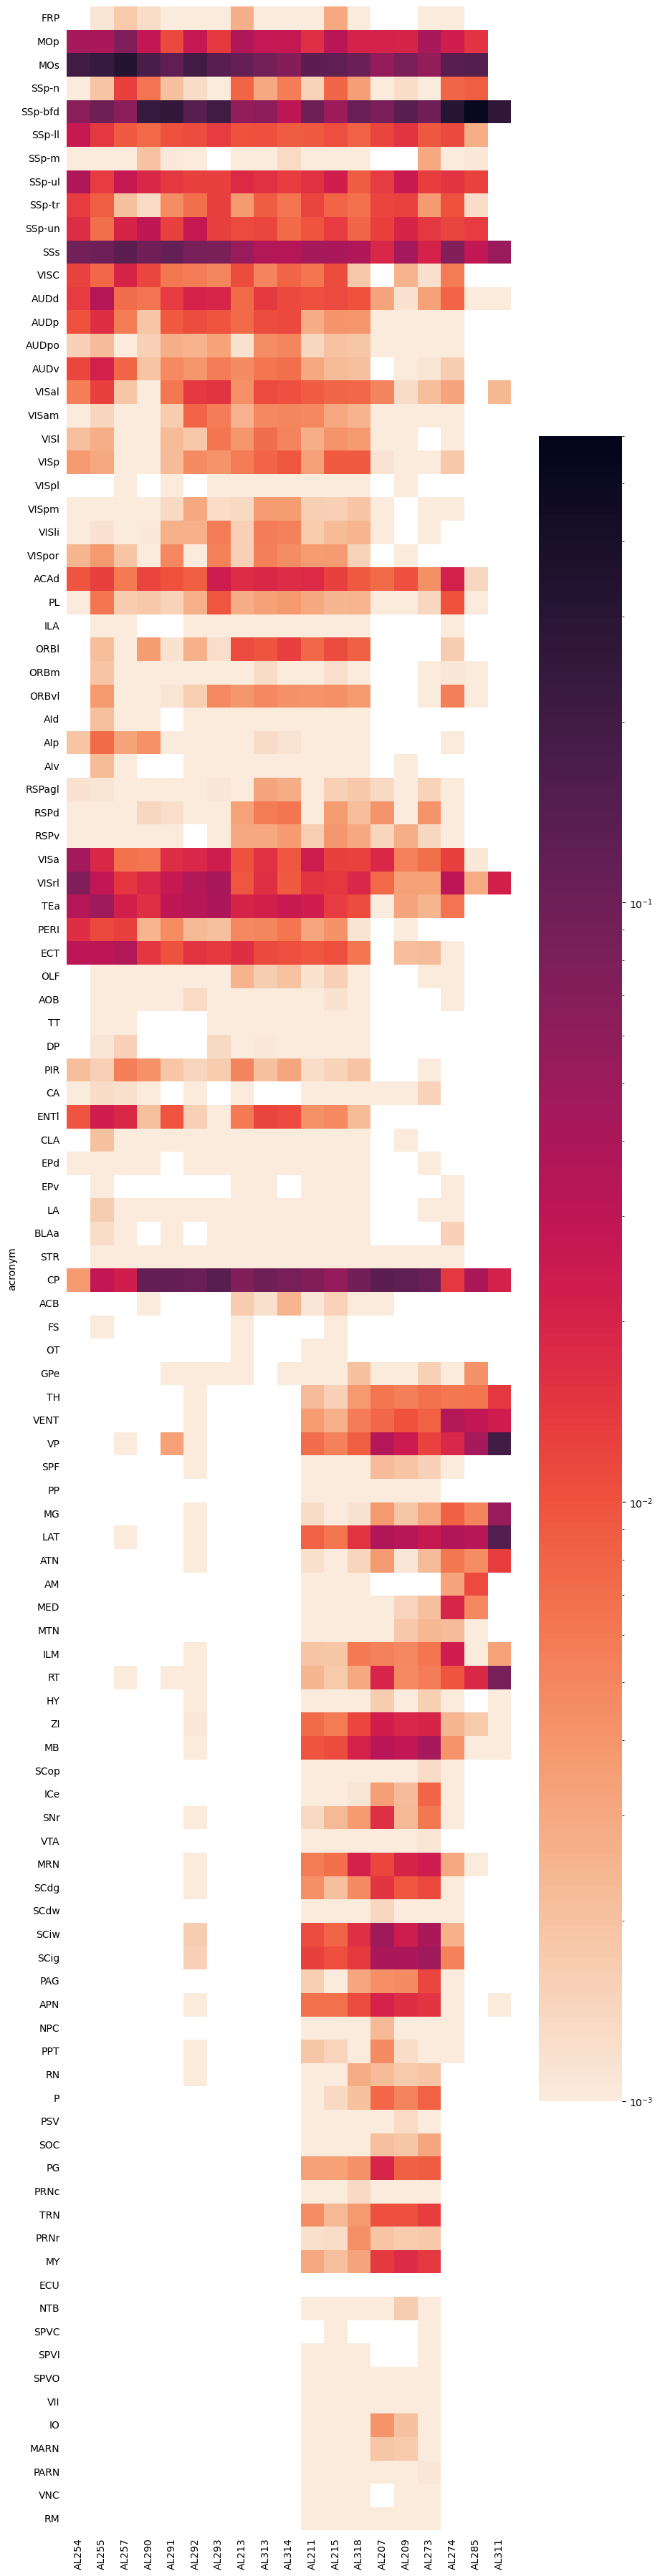

In [16]:
# log color scale, do not change vmin and vmax! 0.001 and 0.6

fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_left, 
                norm=LogNorm(vmin=0.001, vmax= 0.6),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\left_heatmap_logscale.svg')

plt.show()

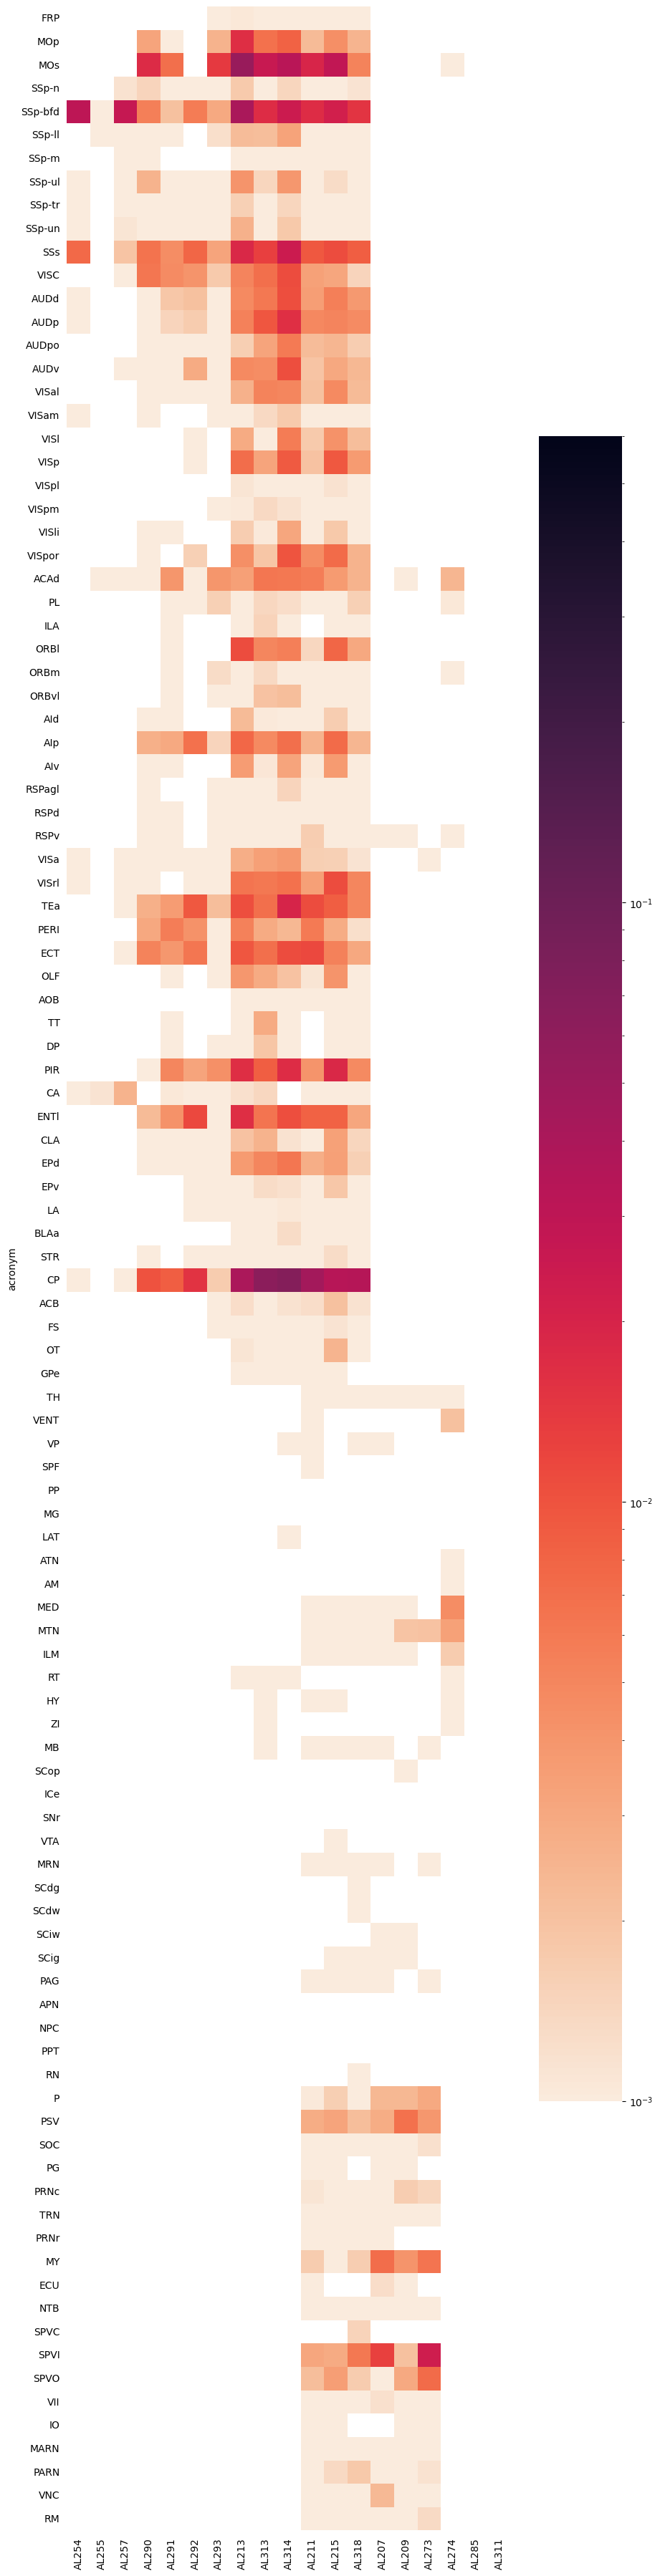

In [17]:
# repeat for right side
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_right, 
                norm=LogNorm(vmin=0.001, vmax= 0.6),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_logscale.svg')

plt.show()

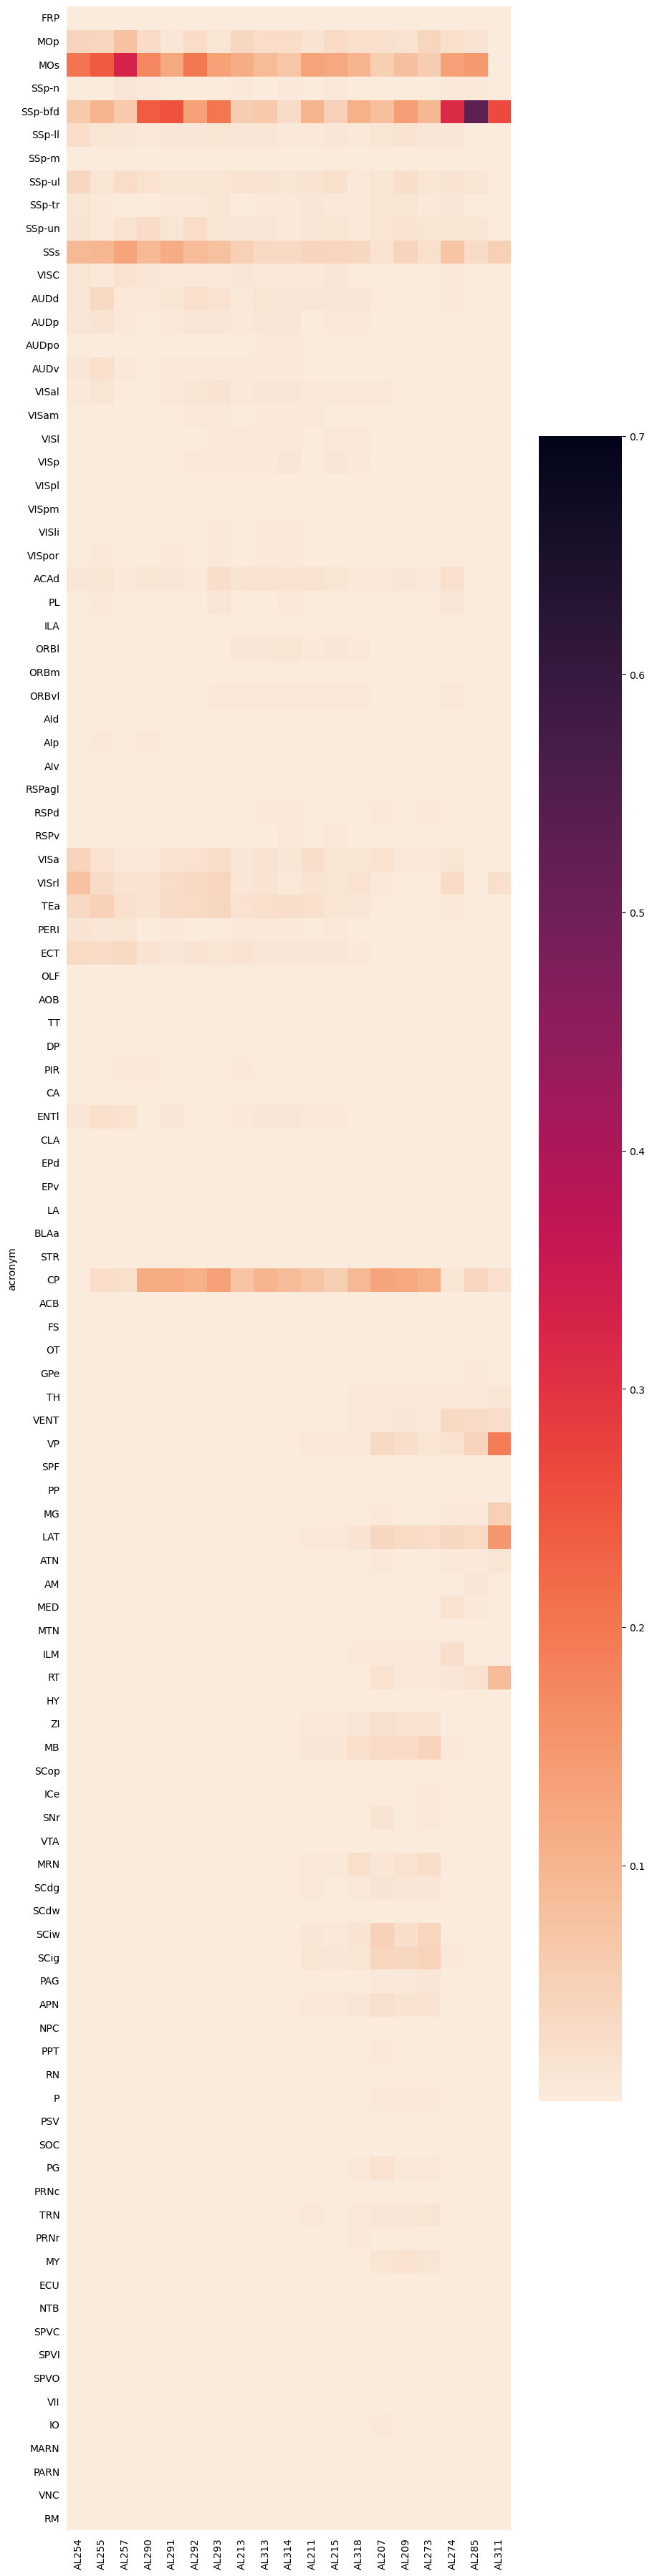

In [18]:
# linear scale, do not change vmin and vmax!! 0.001 and 0.7
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_left, 
                cmap="rocket_r",
                square=True,
                vmin= 0.001,
                vmax=0.7, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\left_heatmap_linearscale.svg')

plt.show()

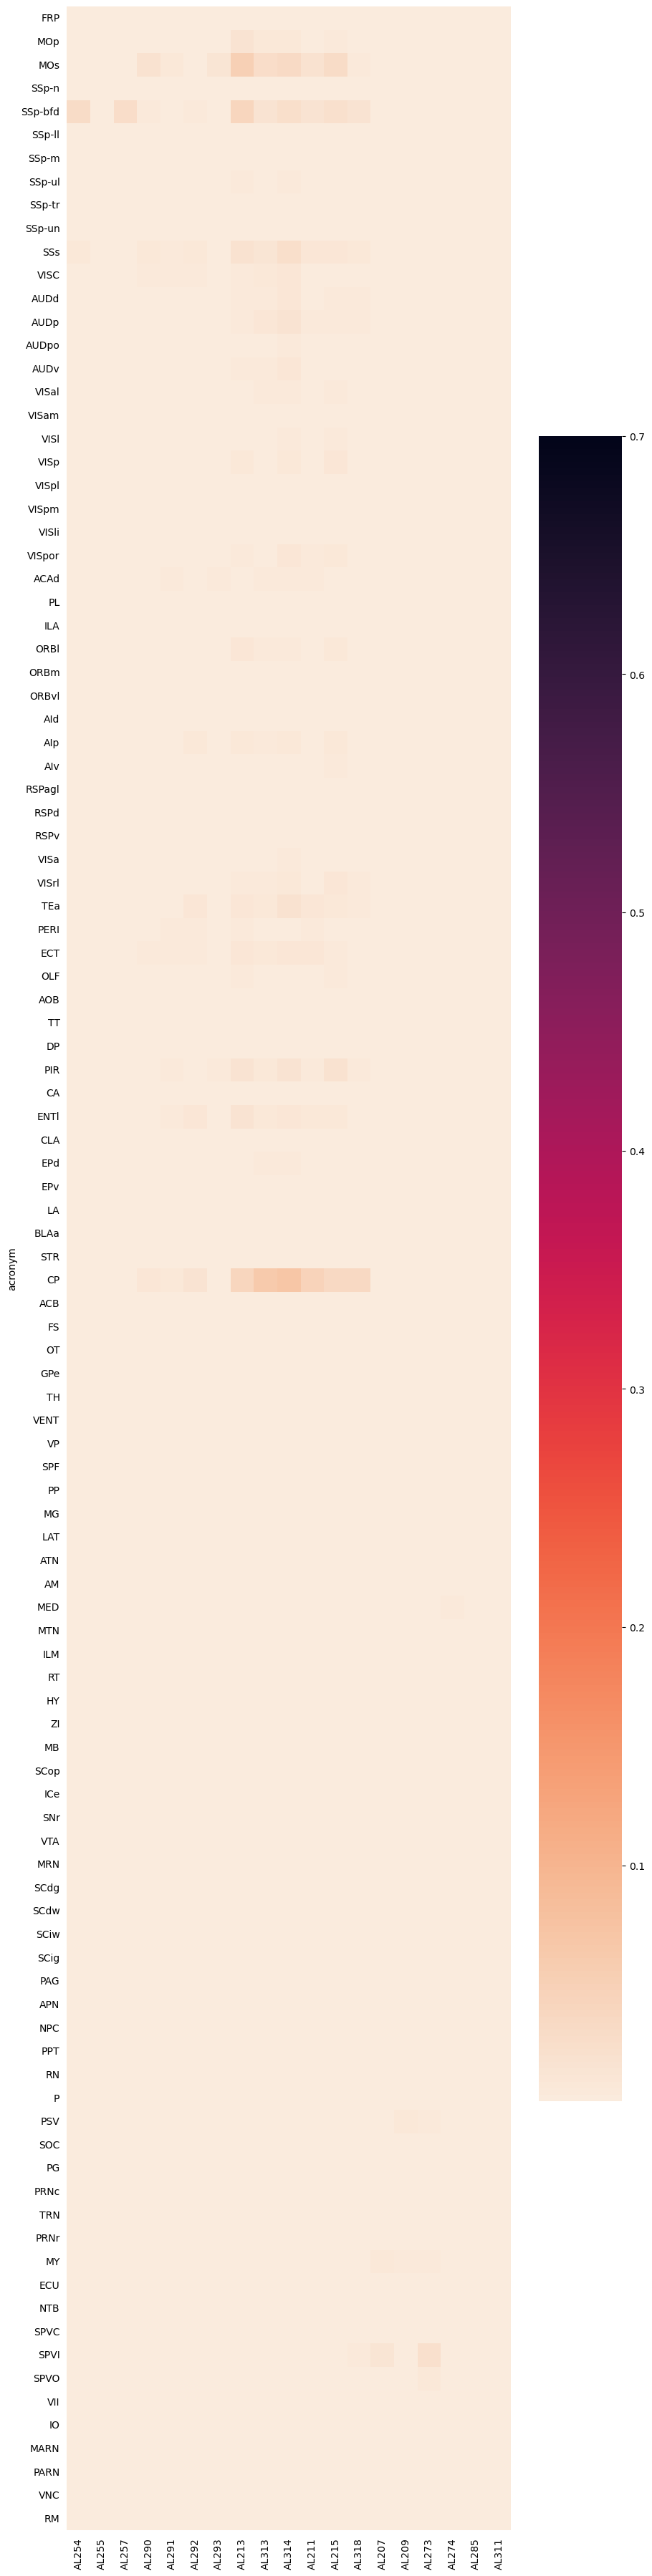

In [19]:
# linear scale, do not change vmin and vmax!! 0.001 and 0.7
# repeat for right side
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_right, 
                cmap="rocket_r",
                square=True,
                vmin= 0.001,
                vmax=0.7, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_linearscale.svg')

plt.show()

### generate a list of abbreviations
Load data from the above seciton first heatmap-for all brain regions in the cerebrum, brainstem and cerebellum

In [14]:
y=df.index.to_list()

full_name=[]
for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

In [17]:
parent_acronyms= {'Acronyms': y, 'Full name': full_name}
acronym_df= pd.DataFrame(data=parent_acronyms)
acronym_df.to_excel('thesis_acronyms.xlsx')

### heatmap for axons in brain region - isocortex only 
id= 315

In [3]:
def norm_region(df, df_r):
    
    ''' Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to
    
    No need to specify column list here since it has been extracted already from combine_df_specific'''
    
    region_sum= df.sum()
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df/all_isocortex
    # divide left side to normalize

    norm_values_r= df_r/all_isocortex
    # divide right side to normalize

    return norm_values,norm_values_r

def plot_log(df,side):

    # log color scale, do not change vmin and vmax! 0.001 and 0.8

    fig, ax = plt.subplots(figsize=(10,10))
    g1= sns.heatmap(df, 
                    norm=LogNorm(vmin=0.001, vmax= 0.8),
                    cmap="rocket_r",
                    square=True,
                    linewidths=0.0,
                    rasterized=True)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!
    g1.set( ylabel=None)

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_logscale.svg')
    plt.show()
    
    return

def plot_lin(df,side):
# linear scale, do not change vmin and vmax, 0 and 0.8

    fig, ax = plt.subplots(figsize=(10,10))
    g1= sns.heatmap(df,
                    cmap="rocket_r",
                    vmin= 0.000,
                    vmax=0.8, 
                    square=True,
                    linewidths=0.0,
                    rasterized=True)
    g1.set( ylabel=None)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_linearscale.svg')

    plt.show()
    
    return

In [4]:
#find all relevant files

folder= r'D:\viral_results\s2'
outdir = r'D:\viral_results\s2_results'
# change s1 to s2

region_id='315'
#isocortex


files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [5]:
#column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

In [6]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]

axonal_df= combine_df_specific(folder, parent_axons,region_id)
axonal_df=axonal_df.T

In [7]:
# plot isocortex only 
side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]

axonal_df_r= combine_df_specific(folder, parent_axons,region_id)
axonal_df_r=axonal_df_r.T

In [8]:
leftside,rightside= norm_region(axonal_df, axonal_df_r)

#normalize by total isocortex axons from both hemispheres

In [9]:
both=pd.concat([leftside,rightside], join='outer', axis=1)
both.fillna(value=0, inplace=True)
# concat so that the same region show up in left and right side
# concat on axis=1 since columns are sample and rows are regions

In [10]:
test=atlas_labels.merge(pd.DataFrame(both.index), on='acronym', how='inner')
order=test.sort_values(by='graph_order')['acronym']

# confirm region ordering by taking the involved acronym, inner merge with atlas labels then order by graph order

final= both.reindex(order)

In [11]:
leftindex= int(len(both.columns)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= final.iloc[:, 0:leftindex]
leftside=leftside[column_order]
# extract first half of the columns , then set column order

rightside=final.iloc[:, leftindex:]
rightside=rightside[column_order]
# repeart for right side

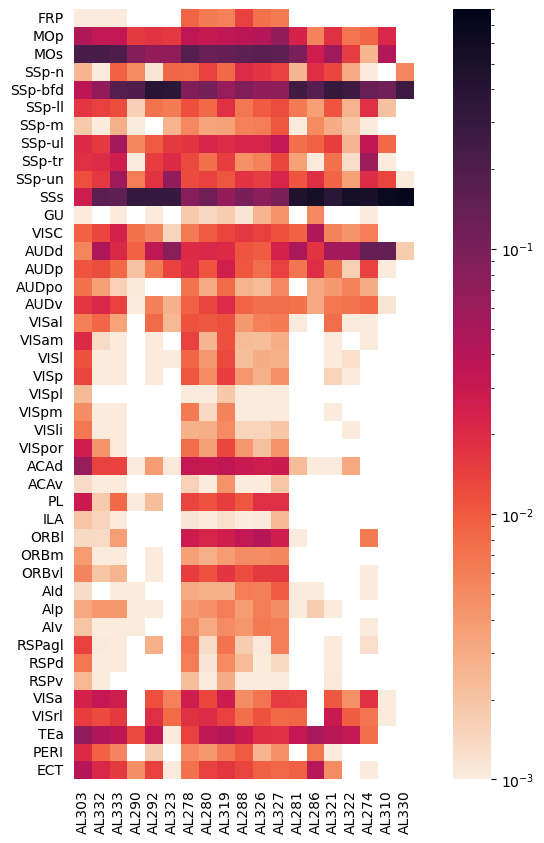

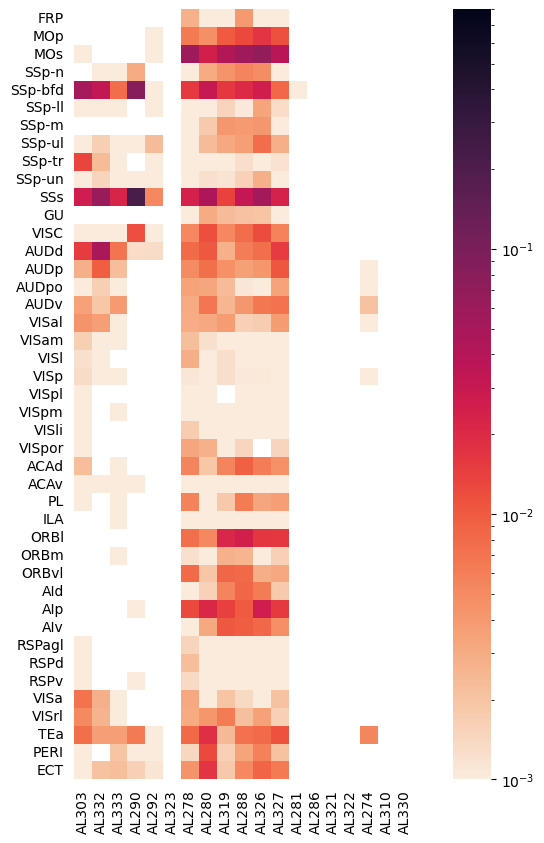

In [12]:
plot_log(leftside,'left')
plot_log(rightside,'right')

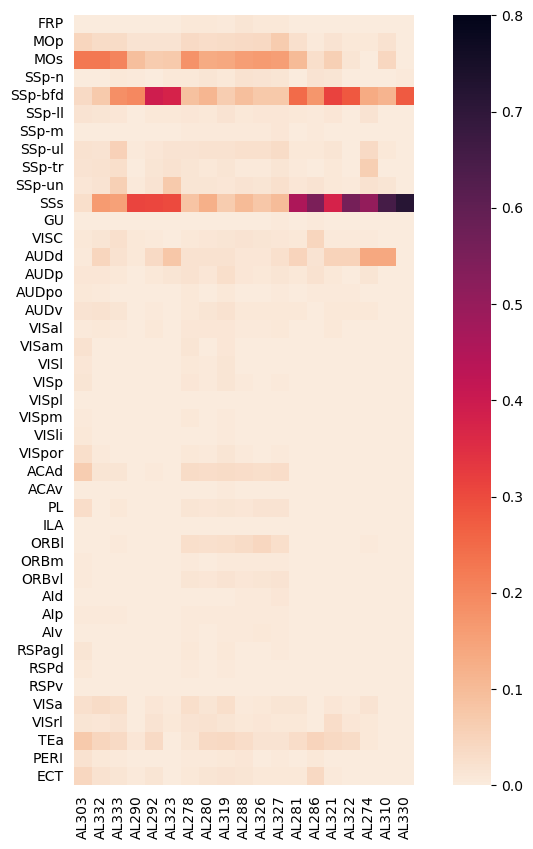

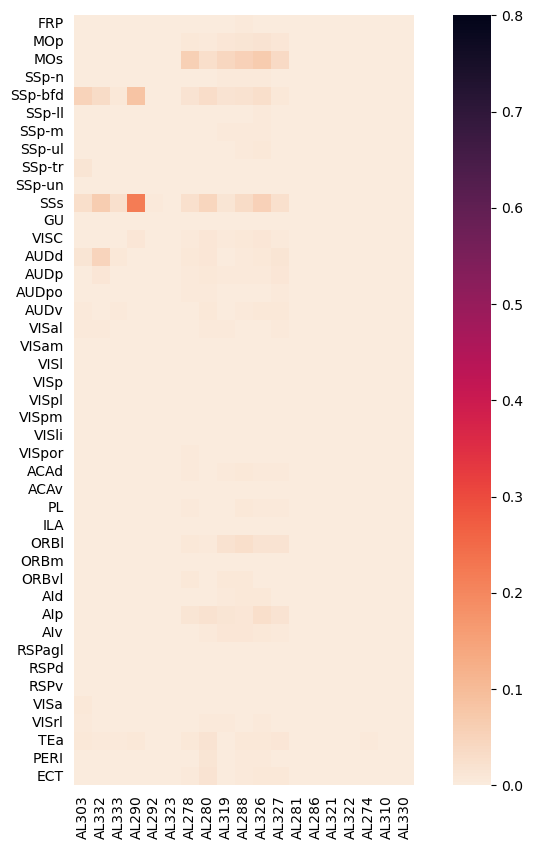

In [13]:
plot_lin(leftside,'left')
plot_lin(rightside,'right')

### plotting correlation matrix with sns

In [3]:
indir= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#             'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'axon_left' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axonal_df_L=axonal_df_L.T

axonal_df_L_ordered=axonal_df_L[column_order]
#order



In [6]:
axons_R= [ i for i  in os.listdir(indir) if 'axon_right' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

axonal_df_R=axonal_df_R.T

axonal_df_R_ordered=axonal_df_R[column_order]
#order

#axonal_df_R_ordered['AL310'][0]=0.00000
# No need to do this if plotting the full correlation (both hemispheres), only do this for plotting right hemisphere correlaiton
# because some brains(such as AL285) have nothing at all in the right hemisphere, correlation will show up as NAN and hence a blank row/column in heatmap
# just assign 1 to a random item so this does not happen

In [7]:
right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [8]:
full_df=pd.concat([axonal_df_L,axonal_df_R])
full_df=full_df[column_order]
#full_df

In [9]:
full_corr=full_df.corr()


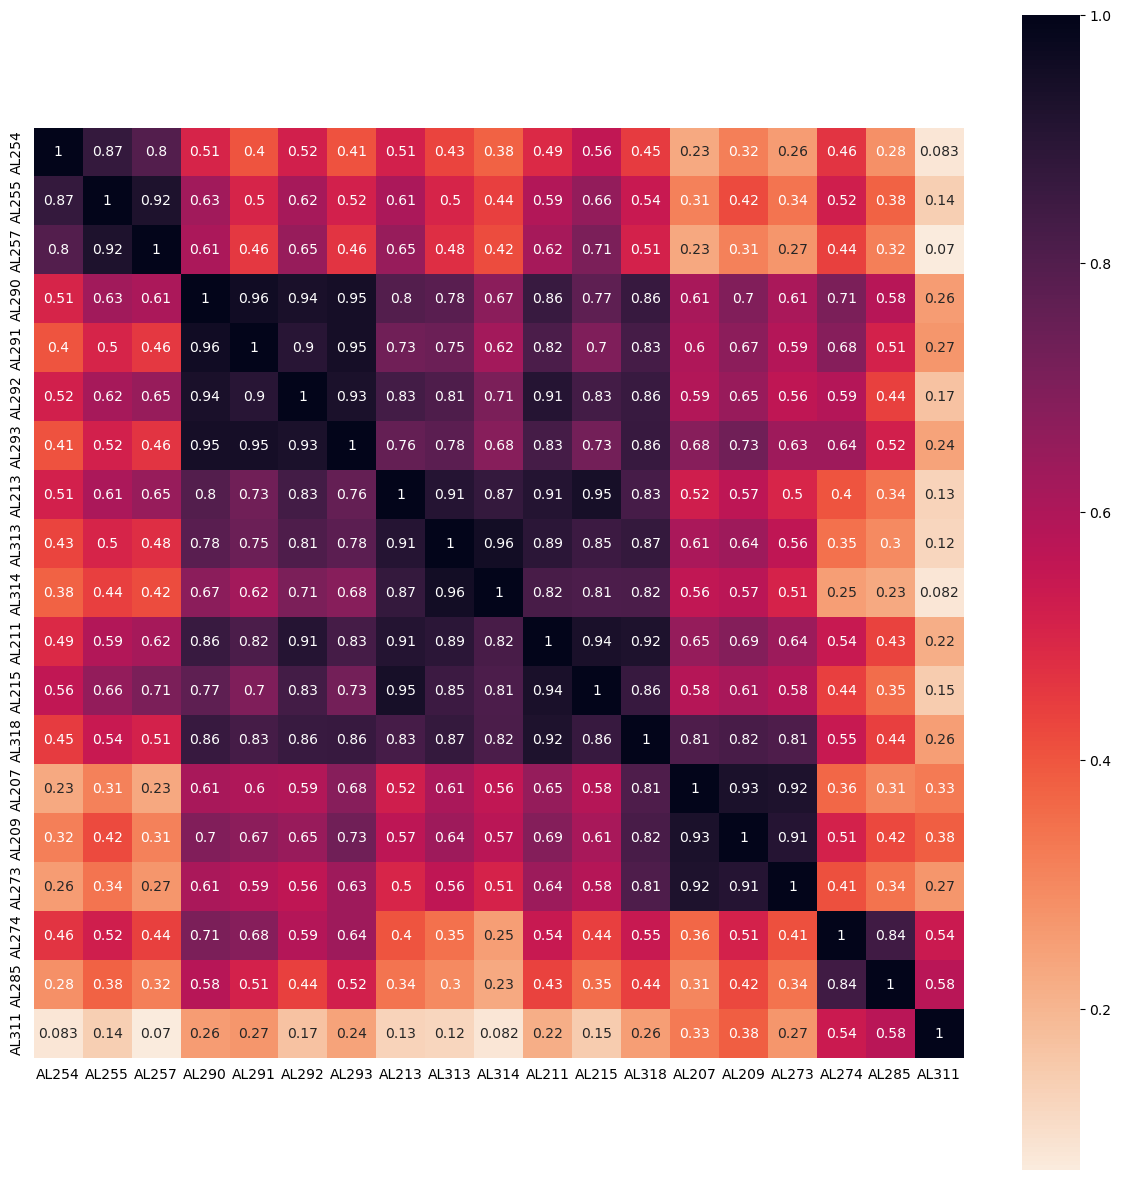

In [10]:

fig, ax = plt.subplots(figsize=(15,15))
g1=sns.heatmap(full_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\full_correlation.svg')
plt.show()

### Section for big regions- depth 2 and 4 
Plot axons in broad groups as overview first

involved regions:


depth 2: 

    '/567/', cerebrum
    '/343/', brainstem
    '/512/', cerebellum


depth 4: 

    '/695/', cortical plate
    '/703/', cortical subplate
    '/477/', striatum
    '/803/', pallidum
    '/549/', thalamus
    '/1097/', hypothalamus
    '/339/', midrbain sensory related
    '/323/', midbrain motor related
    '/348/, midbrain behavioral state related
    '/771/', pons
    '/354/', medulla


not usefule now, depth 3: 

    '/528/', cerebellar cortex
    '/519/', cerebellar nuclei


In [29]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def sum_broad_group (df,sample_list, broad_group):
    '''from data frame, group structures by bigger regions, ie. cortical plate, cortical subplate, etc '''
        
    all_region=pd.DataFrame()

    for i in broad_group: 
        region_id= i
        choosen_regions= df.loc[df['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

        this_region= atlas_labels[atlas_labels['id']==i]

        region_sum= []
        for j in sample_list:
            region_sum.append (choosen_regions[j].sum())

        this_region[sample_list]= region_sum
        this_region['sum']= sum(region_sum)

        all_region= pd.concat([all_region, this_region])
    
    return all_region


def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()

    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it

    side_column= both_df.pop('side')
    both_df.insert(2, "side", side_column, allow_duplicates=False)

    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[3:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-3
    # need to repeat injection site list for x times, minus the index column, the site column, and the side column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1

    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region


    repeated_list_side=[]
    y=0
    while y<to_repeat:
        repeated_list_side.append(both_df['side'].to_list())
        y+=1

    new_list_side = itertools.chain(*repeated_list_side)
    new_list_side=list(new_list_side)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    expand1['side']= new_list_side
# finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df,order):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,10))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.5),
    )

    ax.set(xlim=(0, 1))
    # use the same x range for all plots
    
    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    #plt.savefig(f'{outdir}\\{mouseline}_avg_big.svg')

    plt.show()

    
def bar_plot (expanded_df, order, side, depth, mouseline):
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(15,5))
    
    # keep x at 15, y at whatever depending on amount of acronym (ie, 5 for depth 4, 3 for depth 2)

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!
    
    g1.set(xlabel=None,ylabel=None)

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.5),
    )
    
    g2.set(xlabel=None, ylabel=None)

    ax.set(xlim=(0, 1))
    # use the same x range for all plots

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\\{mouseline}_{depth}_{side}.svg')
    
    plt.show()

#### Section for big regions- non-mirrored bars depth 3 and 4 
deprecated


previous section to plot left and right on the same bar

In [9]:
broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354, 528, 519]
# plot data in broader groups

#broad_group= [315, 698, 1089]
# these are the regions within coprtical plate 695
# isocortex 315, olfactory areas 698, and hippocampal formation 1089


In [10]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

mouseline='ras'
# could be ras, scn, tlx, sim, rbp, or nts
# change manually and run the following cells in the region

In [26]:
side='left'
# could be left or right

region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']= side
df1['side']= side

expanded_left= combine_expanddf(df1,df2)
# combine the two dfs

In [12]:
side='right'
# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

dfr1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
dfr2= extract_df(name_list2,big_df2, region2)
# do the same for s2

dfr2['side']=side
dfr1['side']=side

expanded_right= combine_expanddf(dfr1,dfr2)

right_acronym= [i+'_r' for i in expanded_right['acronym']]
expanded_right['acronym']=right_acronym
# add identifier for the right hemisphere

expanded_both= pd.concat([expanded_left,expanded_right])
expanded_both=expanded_both.sort_values(by=['acronym'])
# sort by acronym so a given region from left and right are ordered together

In [13]:
expanded_both= pd.concat([expanded_left,expanded_right], ignore_index=True)
expanded_both=expanded_both.sort_values(by=['site'], ascending=False)
# sort by site first so that s1 is red and s2 is blue..consistent with other bar plots

In [14]:
order= ['CTXpl','CTXpl_r',
       'CTXsp','CTXsp_r',
       'STR','STR_r',
       'PAL','PAL_r',
       'TH','TH_r',
       'HY','HY_r',
       'MBsen','MBsen_r',
       'MBmot','MBmot_r',
        'MBsta','MBsta_r',
        'P','P_r',
        'MY','MY_r',
        'CBX','CBX_r',
        'CBN','CBN_r'
       ]
    
# order the bar graph so it make sense and left and right stay together

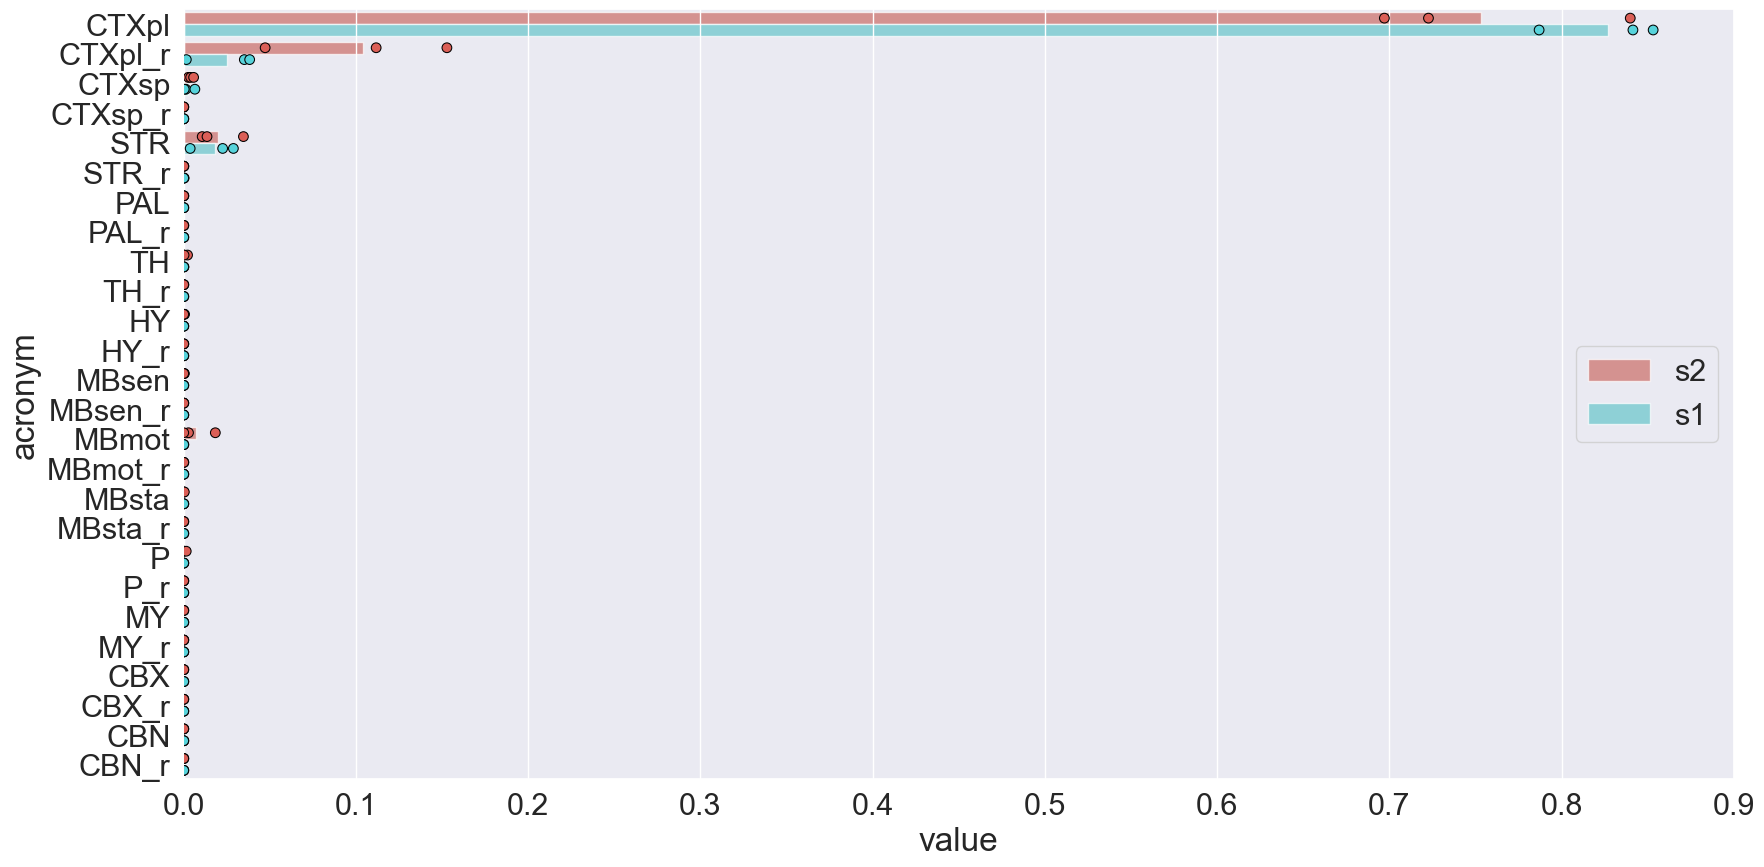

In [15]:
grouped_bar(expanded_both, order)

#### section to plot depth 2 and 4 mirrored bars for left and right

new update as of june 29 2023

In [23]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')
outdir= r'D:\\viral_results\\s1_s2'


In [5]:
depth = 4

mouseline='ras'
# could be ras, scn, tlx, sim, rbp, or nts

side= 'left'
# change manually and run the following cells in the region

In [8]:
if depth== 4:
    
    broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354]
    # depth 4 plot order
    order= ['CTXpl','CTXsp','STR','PAL','TH','HY','MBsen','MBmot','MBsta','P','MY']
    
elif depth== 2: 
    # depth 2 order
    order= ['CH','BS', 'CB']
    broad_group= [567,343,512]

# identify which level of grouping is involved
# order the bar graph so it make sense and left and right stay together

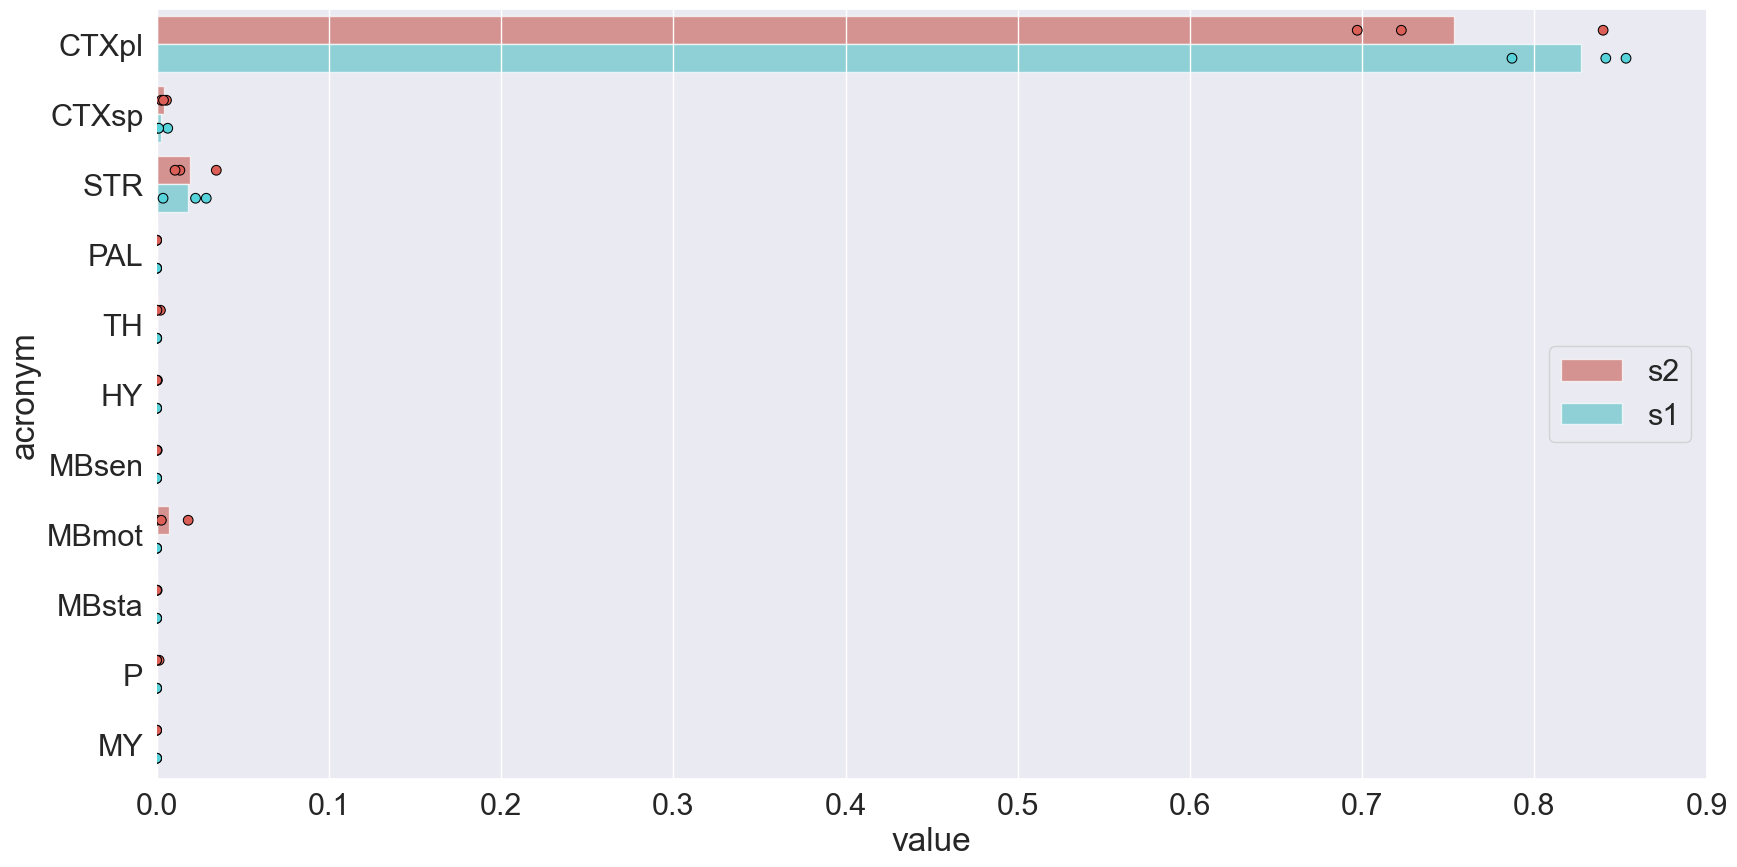

In [9]:

region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']= side
df1['side']= side

expanded= combine_expanddf(df1,df2)
# combine the two dfs
expanded= expanded.sort_values(by=['site'], ascending=False)

#bar_plot (expanded, order, side, depth,mouseline)
grouped_bar(expanded,order)

In [30]:
### loooop!
depth = 4

mouseline=['ras', 'scn', 'tlx', 'sim', 'rbp', 'nts']
# could be ras, scn, tlx, sim, rbp, or nts

side= ['left', 'right']


In [31]:
if depth== 4:
    
    broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354]
    # depth 4 plot order
    order= ['CTXpl','CTXsp','STR','PAL','TH','HY','MBsen','MBmot','MBsta','P','MY']
    
elif depth== 2: 
    # depth 2 order
    order= ['CH','BS', 'CB']
    broad_group= [567,343,512]

# identify which level of grouping is involved
# order the bar graph so it make sense and left and right stay together

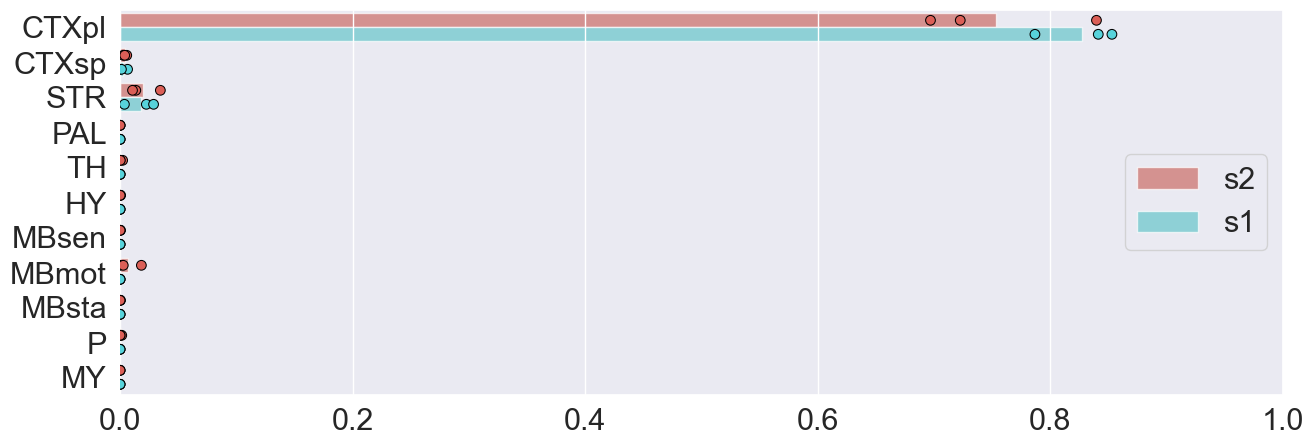

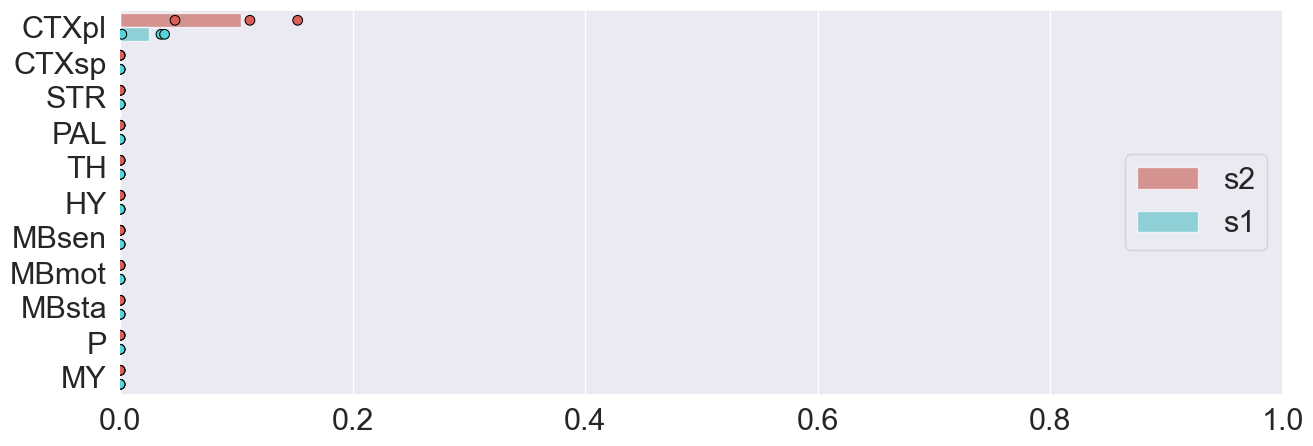

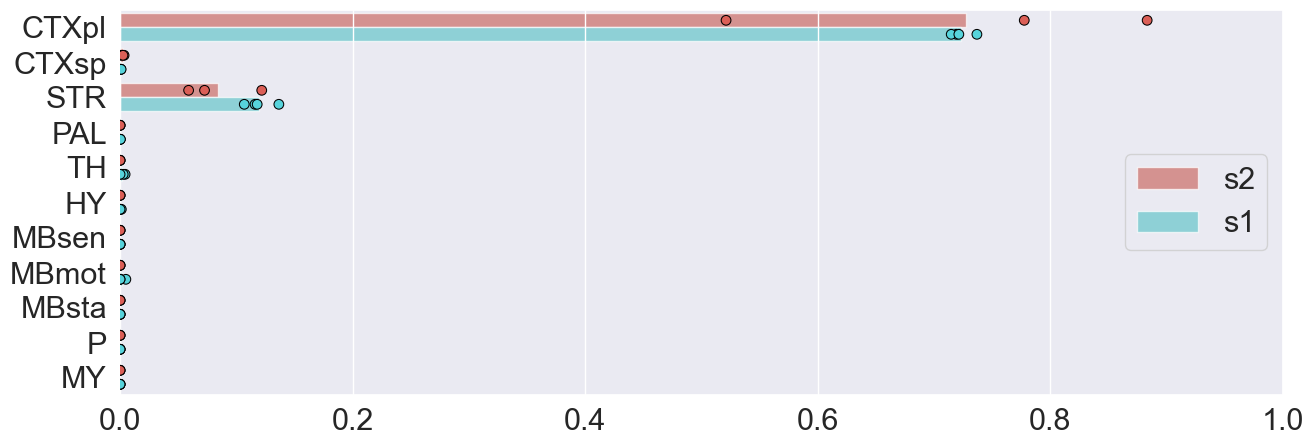

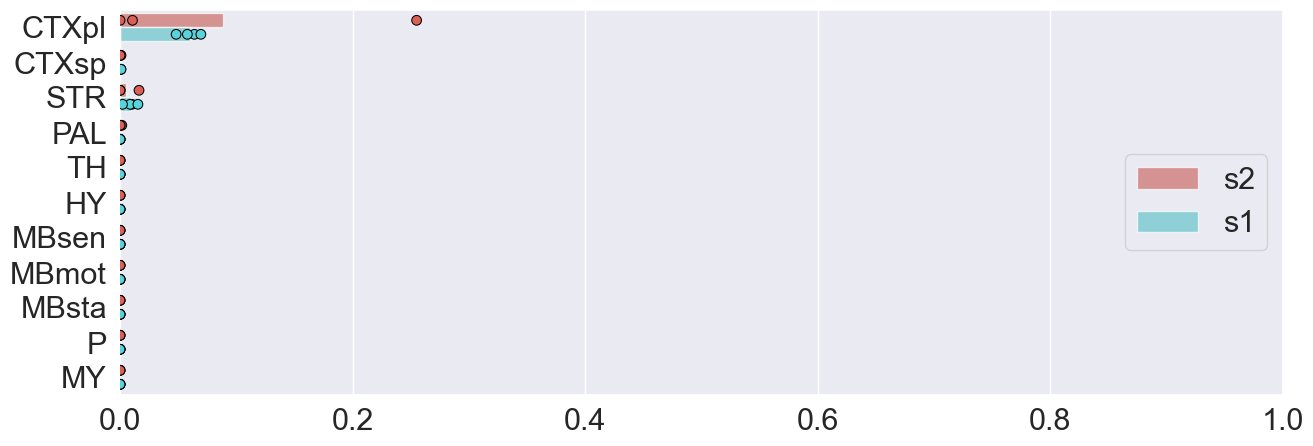

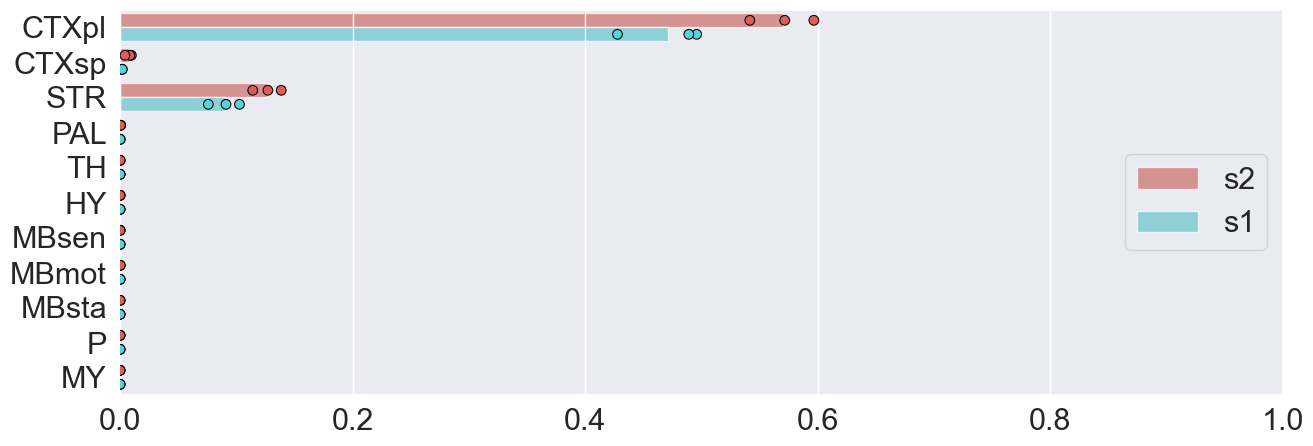

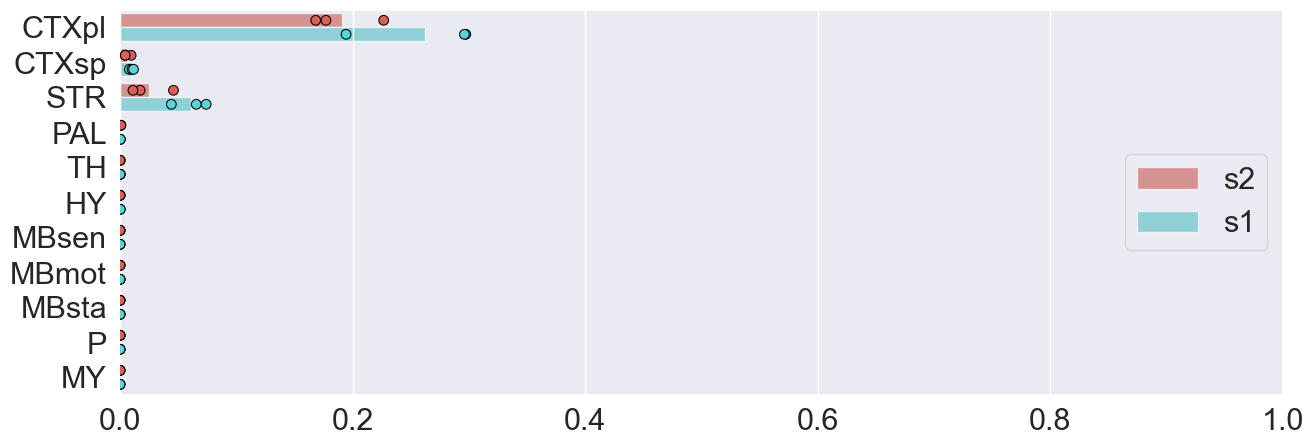

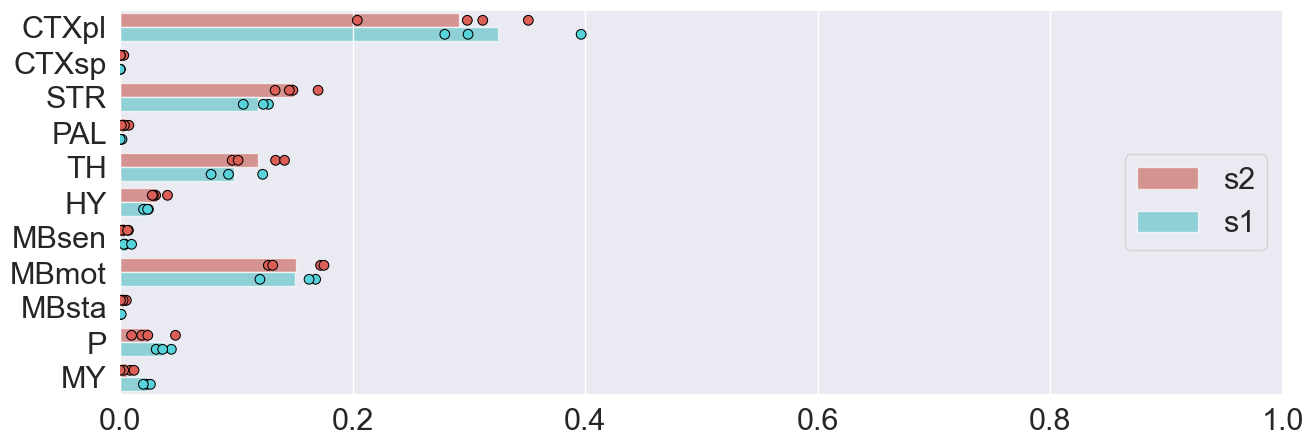

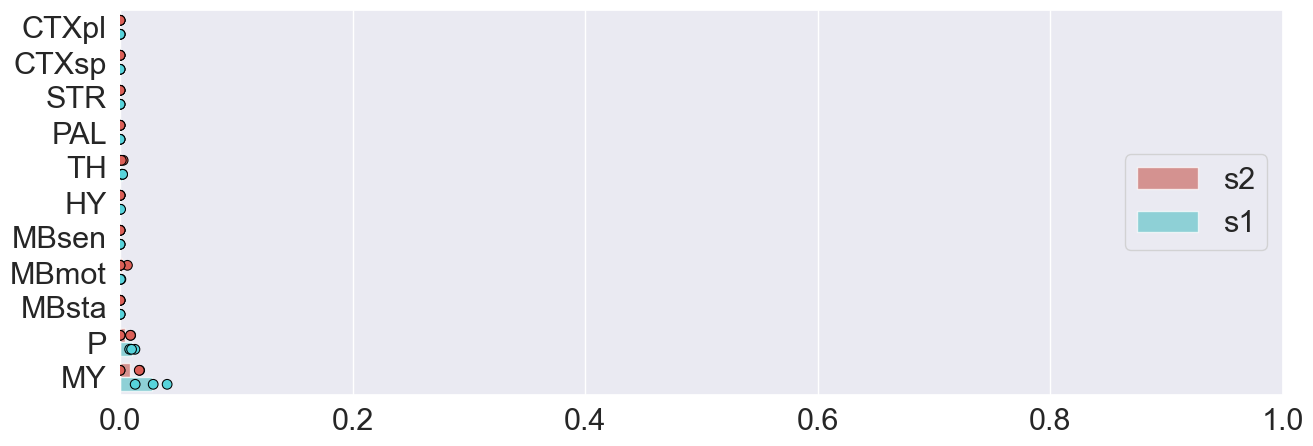

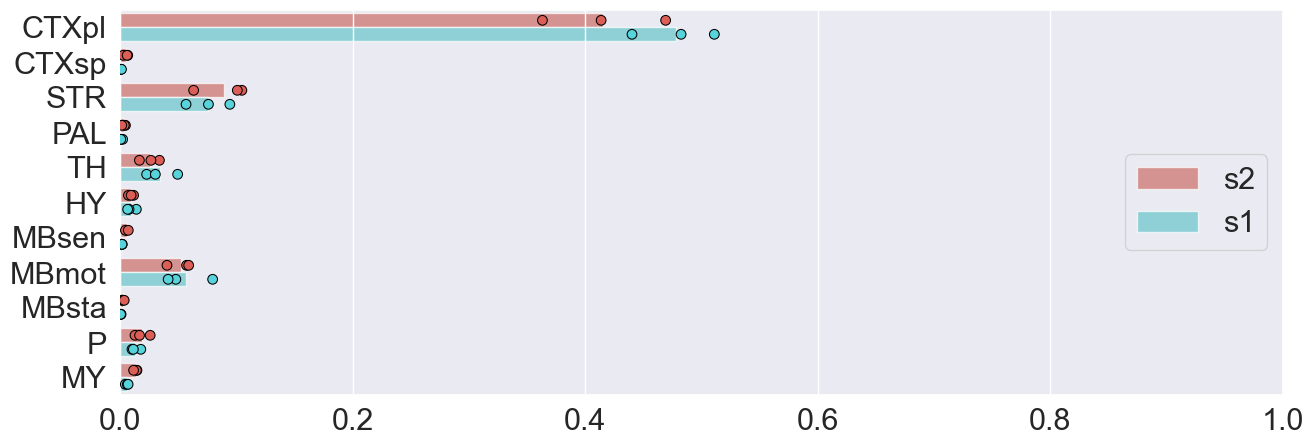

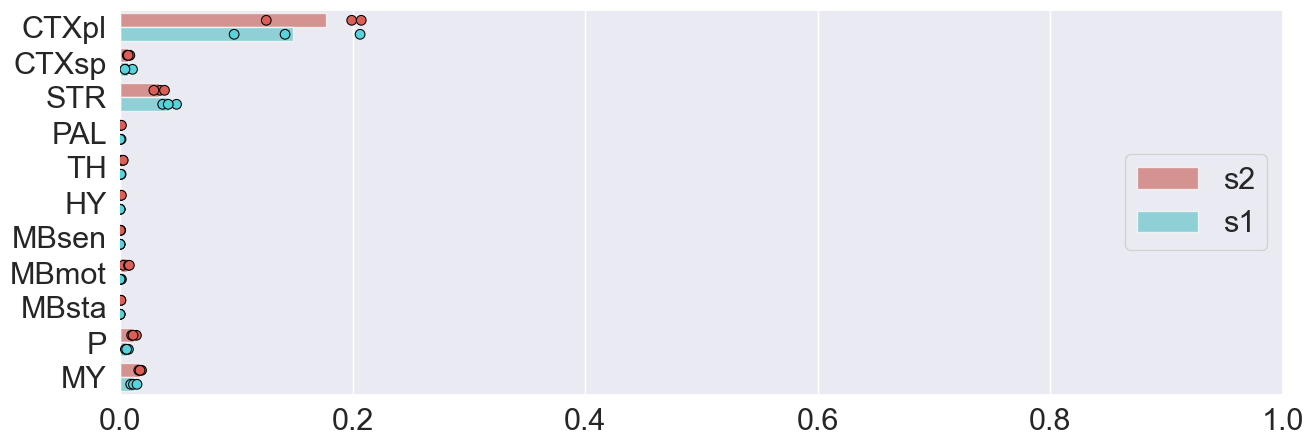

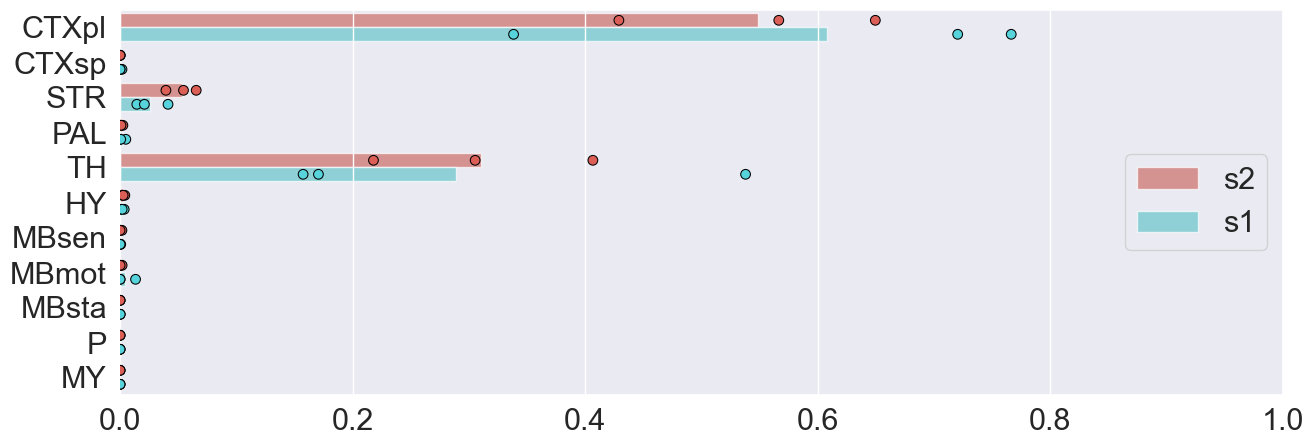

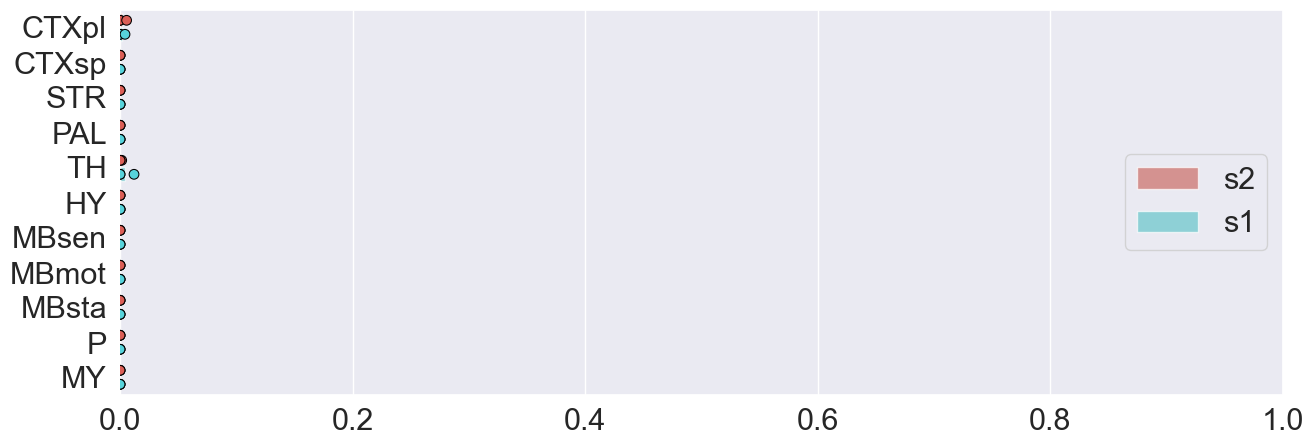

In [32]:
for i in mouseline:
    
    for j in side:

        region='s1'
        file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{j}.xlsx'
        read_file= pd.read_excel(file_path)
        #read_file['injection']=region

        region2='s2'
        file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{i}_avg_{j}.xlsx'
        read_file2= pd.read_excel(file_path2)
        #read_file2['injection']=region2

        name_list1=find_sample_list(read_file)
        #find the list of involved sample

        big_df1= sum_broad_group (read_file,name_list1, broad_group)
        # sum up regions that belong to the same broad group

        df1= extract_df(name_list1,big_df1, region)
        # extract only the useful informations

        name_list2=find_sample_list(read_file2)
        big_df2= sum_broad_group (read_file2,name_list2, broad_group)
        df2= extract_df(name_list2,big_df2, region2)
        # do the same for s2

        df2['side']= j
        df1['side']= j

        expanded= combine_expanddf(df1,df2)
        # combine the two dfs
        expanded= expanded.sort_values(by=['site'], ascending=False)

        bar_plot (expanded, order, j, depth,i)


#### test section for mannwhitneyu test



In [198]:
from scipy.stats import mannwhitneyu
# left side
side= 'left'

if side=='left':
    both_df= pd.concat([df1, df2])
elif side=='right':
    both_df= pd.concat([dfr1, dfr2])

both_df=both_df.reset_index()
# combine the two df from s1 and s2 first

site_column= both_df.pop('site')
both_df.insert(1, "site", site_column, allow_duplicates=False)
# always make sure that the first column is index and secon column is injection site

In [199]:
both_df

acronym,index,site,CTXpl,CTXsp,STR,PAL,TH,HY,MBsen,MBmot,MBsta,P,MY,CBX,CBN,side
0,AL211,s1,0.511199,0.000618,0.076011,0.000617,0.030343,0.007712,0.00137,0.04795,0.000445,0.011423,0.004528,0.0,0.000025,left
1,AL215,s1,0.482588,0.000626,0.056762,0.00024,0.02286,0.006525,0.001887,0.041353,0.000279,0.010274,0.006221,0.0,0.000009,left
2,AL318,s1,0.440368,0.001182,0.094433,0.002222,0.049533,0.013987,0.001635,0.079628,0.000867,0.01781,0.006899,0.0,0.0,left
3,AL288,s2,0.469306,0.002701,0.063284,0.001423,0.01663,0.007182,0.005513,0.040358,0.001561,0.01284,0.014514,0.000007,0.000078,left
4,AL326,s2,0.363326,0.006077,0.104773,0.004612,0.033848,0.011613,0.004603,0.057172,0.002409,0.016745,0.014102,0.0,0.000189,left
5,AL327,s2,0.413814,0.006576,0.100851,0.003658,0.026553,0.00951,0.007063,0.059012,0.003546,0.0259,0.011639,0.000011,0.000134,left


In [207]:
s1 = both_df[both_df['site']=='s1']
s2 = both_df[both_df['site']=='s2']

class1=pd.to_numeric(s1['CTXpl'])
class2=pd.to_numeric(s2['CTXpl'])

#stats,pvalue= mannwhitneyu(class1, class2, alternative='two-sided',method='auto')
print(np.mean(class1))
print(np.std(class1))

0.47805172844693206
0.029093987368601876


In [203]:
f=open(f'{outdir}\\{mouseline}_avg_{side}_big.txt','w+')

for i in both_df.columns[2:-1]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    # also remove the side column
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= mannwhitneyu(class1, class2, alternative='two-sided',method='auto')

    print(f'{i}, p value = {pvalue}, stats= {stats} \n ')
    f.write(f'{i}, p value = {pvalue}, stats= {stats}\n ')

f.close()
    

CTXpl, p value = 0.2, stats= 8.0 
 
CTXsp, p value = 0.1, stats= 0.0 
 
STR, p value = 0.4, stats= 2.0 
 
PAL, p value = 0.2, stats= 1.0 
 
TH, p value = 0.7, stats= 6.0 
 
HY, p value = 1.0, stats= 4.0 
 
MBsen, p value = 0.1, stats= 0.0 
 
MBmot, p value = 1.0, stats= 5.0 
 
MBsta, p value = 0.1, stats= 0.0 
 
P, p value = 0.4, stats= 2.0 
 
MY, p value = 0.1, stats= 0.0 
 
CBX, p value = 0.19670560245894686, stats= 1.5 
 
CBN, p value = 0.1, stats= 0.0 
 


In [205]:
## try just t test??
from scipy.stats import ttest_ind

for i in both_df.columns[2:-1]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    # also remove the side column
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= ttest_ind(class1, class2, equal_var=False)

    print(f'{i}, p value = {pvalue}, stats= {stats} \n ')

CTXpl, p value = 0.17509021010566983, stats= 1.696718192219486 
 
CTXsp, p value = 0.0681336599078588, stats= -3.500319154913961 
 
STR, p value = 0.4640045214867387, stats= -0.811864564996618 
 
PAL, p value = 0.13333018919982126, stats= -1.9624290220668983 
 
TH, p value = 0.42165201515303385, stats= 0.9134239929584765 
 
HY, p value = 0.9924303506166708, stats= -0.010266661719530975 
 
MBsen, p value = 0.025350712006681722, stats= -5.584845462100573 
 
MBmot, p value = 0.7755422127667884, stats= 0.31236603309387806 
 
MBsta, p value = 0.06467877900598434, stats= -3.285922988391271 
 
P, p value = 0.31716975441891676, stats= -1.1771056733998344 
 
MY, p value = 0.0032994767406353247, stats= -6.602188878384259 
 
CBX, p value = 0.20108309172274022, stats= -1.8785522610403718 
 
CBN, p value = 0.055112468161783244, stats= -3.739396437881803 
 


### section to plot bar graphs- a given region for s1 vs s2 comparison

layers combined!

isocortex 315

in grouped bar, have color specification -> useful for other bar plots

updated July 03 2023:
    
    matching acronym for left and right hemisphere even if its 0 for many, for direct mirroring comparison


In [3]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def norm_region(df, df_r, sample_list):
    
    ''' Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to'''
    
    region_sum= df.sum()[sample_list]
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()[sample_list]
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df[sample_list]/all_isocortex
    # divide left side to normalize
    df[sample_list]= norm_values

    norm_values_r= df_r[sample_list]/all_isocortex
    # divide right side to normalize
    df_r[sample_list]= norm_values_r

    return df, df_r


def prepare_parent(df, sample_list):
    test=df.groupby(['parent_structure_id'],as_index=False)[sample_list].sum()
    # group each region based on parent structure id so that layers are combined and values summed
    # here the [sample_list] is stated explicitly because pandas will drop nuisance columns when doing groupby

    parent_structureid= test.pop('parent_structure_id')
    # store the parent structure id and remove it from the df
    #test['id']=parent_structureid
    # now the id of each acronym is its parent id

    extract_sample=test[sample_list]
    # extract only the sample names and assign to new data frame
    extract_sample['id']=parent_structureid
    # add the id to this new data frame so next we can merge with atlas label

    result = pd.merge(extract_sample, atlas_labels, on=["id"])
    # merge with atlas label on id, now all information is true such that we can do further grouping, ordering, etc based on this data frame
    
    return result
    
def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1


def grouped_bar(expanded_df,order, side):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''
    
    color= [sns.hls_palette()[0],sns.hls_palette()[3]] 
    # specify the color template so that  s1 is always hls palette 3 (a cyan like color) and s2 is always hls palette 0 (a reddish color)
    # here we indicate s2 first because usually the bar graphs show s2 first (data frame sort_values by site, ascending=False)

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,15))
    # (width, height)

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette=color,
        order=order,
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )
    
    g1.set(xlabel=None, ylabel=None)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette=color,
        order=order,
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )
    
    g2.set(xlabel=None, ylabel=None)
    
    ax.set(xlim=(0, 0.8))
    # do not change this xlim for this plot

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    plt.savefig(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.svg')

    plt.show()

In [4]:
outdir= r'D:\\viral_results\\s1_s2'
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

mouseline='ras'
# could be ras, scn, tlx, rbp, sim, or nts
# dont forget to change the xlim range accordingly for each line- ras 0.4  sim 0.6, scn0.4 rbp 0.3, tlx 0.2, nts 0.8

region_id='315'
# isocortex

In [16]:
side='left'

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2= choosen_regions2.sort_values('graph_order', ascending=True)


In [17]:
# now load and prepare data from right side
side='right'

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)

choosen_regions_r= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions_r= choosen_regions_r.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2_r= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2_r= choosen_regions2_r.sort_values('graph_order', ascending=True)

In [7]:
s1_list=find_sample_list(choosen_regions)
s2_list=find_sample_list(choosen_regions2)
# find relevant samples list 

In [20]:
s1_norm, s1_norm_r=norm_region(choosen_regions,choosen_regions_r, s1_list)
# normalize values to the total axons in both isocortexes, return left and right data frames
s2_norm, s2_norm_r=norm_region(choosen_regions2, choosen_regions2_r, s2_list)
# repeat for s2 injections

# summ up layer info for s1, left and right kept in separate data frames
s1_parent= prepare_parent(s1_norm, s1_list)
s1_parent_r= prepare_parent(s1_norm_r, s1_list)
s1_parent.sort_values(by='graph_order', inplace=True)
#sort by graph order so regions that make sense are together

# summ up layer info for s2, left and right
s2_parent= prepare_parent(s2_norm, s2_list)
s2_parent_r= prepare_parent(s2_norm_r, s2_list)
s2_parent.sort_values(by='graph_order', inplace=True)


In [26]:
s1_parent

,AL254,AL255,AL257,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
6,0.000000,0.001363,2.025766e-03,184,871.0,"Frontal pole, cerebral cortex",FRP,8,1,3,...,6,/997/8/567/688/695/315/184/,268F45,NaN,NaN,f,7,2565719060,734881840,Frontal pole cerebral cortex
32,0.052369,0.049751,8.944011e-02,985,830.0,Primary motor area,MOp,8,1,3,...,18,/997/8/567/688/695/315/500/985/,1F9D5A,NaN,NaN,f,19,1852742012,734881840,Primary motor area
33,0.251746,0.298548,3.842818e-01,993,831.0,Secondary motor area,MOs,8,1,3,...,24,/997/8/567/688/695/315/500/993/,1F9D5A,NaN,NaN,f,25,1043755260,734881840,Secondary motor area
10,0.000271,0.002358,1.522450e-02,353,751.0,"Primary somatosensory area, nose",SSp-n,9,1,3,...,44,/997/8/567/688/695/315/453/322/353/,188064,NaN,NaN,f,45,3014838097,734881840,Primary somatosensory area nose
7,0.076024,0.123579,7.398457e-02,329,748.0,"Primary somatosensory area, barrel field",SSp-bfd,9,1,3,...,51,/997/8/567/688/695/315/453/322/329/,188064,NaN,NaN,f,52,3406319794,734881840,Primary somatosensory area barrel field
8,0.031702,0.017604,1.073809e-02,337,749.0,"Primary somatosensory area, lower limb",SSp-ll,9,1,3,...,65,/997/8/567/688/695/315/453/322/337/,188064,NaN,NaN,f,66,533428449,734881840,Primary somatosensory area lower limb
9,0.000027,0.000047,9.207286e-04,345,750.0,"Primary somatosensory area, mouth",SSp-m,9,1,3,...,72,/997/8/567/688/695/315/453/322/345/,188064,NaN,NaN,f,73,2638278704,734881840,Primary somatosensory area mouth
12,0.046958,0.016822,3.125804e-02,369,753.0,"Primary somatosensory area, upper limb",SSp-ul,9,1,3,...,79,/997/8/567/688/695/315/453/322/369/,188064,NaN,NaN,f,80,3184285306,734881840,Primary somatosensory area upper limb
11,0.016930,0.010590,2.407083e-03,361,752.0,"Primary somatosensory area, trunk",SSp-tr,9,1,3,...,86,/997/8/567/688/695/315/453/322/361/,188064,NaN,NaN,f,87,2078745056,734881840,Primary somatosensory area trunk
39,0.020932,0.008514,2.302603e-02,182305689,NaN,"Primary somatosensory area, unassigned",SSp-un,9,1,3,...,93,/997/8/567/688/695/315/453/322/182305689/,188064,NaN,NaN,f,94,10092796,734881840,Primary somatosensory area unassigned


In [9]:
s1_df= extract_df(s1_list, s1_parent,'s1')
s2_df= extract_df(s2_list, s2_parent,'s2')
# extract only sample name, values and acronym, fill in injection site info

s1_df_r= extract_df(s1_list, s1_parent_r,'s1')
s2_df_r= extract_df(s2_list, s2_parent_r,'s2')
# repeat for right side

In [10]:
# prepare to combine the two sides
leftside=pd.concat([s1_df,s2_df])
rightside= pd.concat([s1_df_r, s2_df_r])

both=pd.concat([leftside,rightside])
both.fillna(value=0, inplace=True)
# concatinate two side so all region show up in both side, that is filled with zero

side_column= both.pop('site')
both.insert(0, "site", side_column, allow_duplicates=False)
# such that site info is always at index 0

#order=both.columns[1:]# extract appropriate column order excluding the first column (site, index 0) for plotting

In [11]:
test=atlas_labels.merge(pd.DataFrame(both.columns[1:]), on='acronym', how='inner')
order=test.sort_values(by='graph_order')['acronym']

#order=order.to_list()

# confirm region ordering by taking the involved acronym, inner merge with atlas labels then order by graph order


In [14]:
leftside

acronym,site,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,...,RSPagl,RSPd,RSPv,VISa,VISrl,TEa,ECT,GU,AId,AIv
AL274,s1,0.000319,0.031344,0.188341,0.010752,0.438673,0.015930,0.000085,0.021161,0.013953,...,0.000290,0.001261,0.000644,0.017526,0.042505,0.008981,0.000015,0.000000,0.000000,0.000000
AL285,s1,0.000000,0.019736,0.192185,0.011332,0.690660,0.003545,0.001396,0.015921,0.001641,...,0.000000,0.000000,0.000000,0.001376,0.003729,0.000000,0.000000,0.000000,0.000000,0.000000
AL311,s1,0.000000,0.000000,0.000000,0.000000,0.778023,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.064789,0.000000,0.000000,0.000000,0.000000,0.000000
AL274,s2,0.000000,0.008724,0.002621,0.000511,0.132188,0.018415,0.000063,0.034578,0.060011,...,0.001252,0.000000,0.000000,0.017837,0.006914,0.007641,0.000152,0.000493,0.000224,0.000065
AL310,s2,0.000000,0.021429,0.042212,0.000000,0.115196,0.002079,0.000000,0.008228,0.000201,...,0.000000,0.000000,0.000000,0.000291,0.000127,0.000000,0.000000,0.000000,0.000000,0.000000
AL330,s2,0.000000,0.000000,0.000000,0.005423,0.275418,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
leftindex= int(len(both)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= both.iloc[0:leftindex]
rightside=both.iloc[leftindex:]

expanded= combine_expanddf(leftside[leftside.site=='s1'],leftside[leftside.site=='s2'])
expanded_r= combine_expanddf(rightside[rightside.site=='s1'],rightside[rightside.site=='s2'])
# expand in to bar+ strip plot format using melt

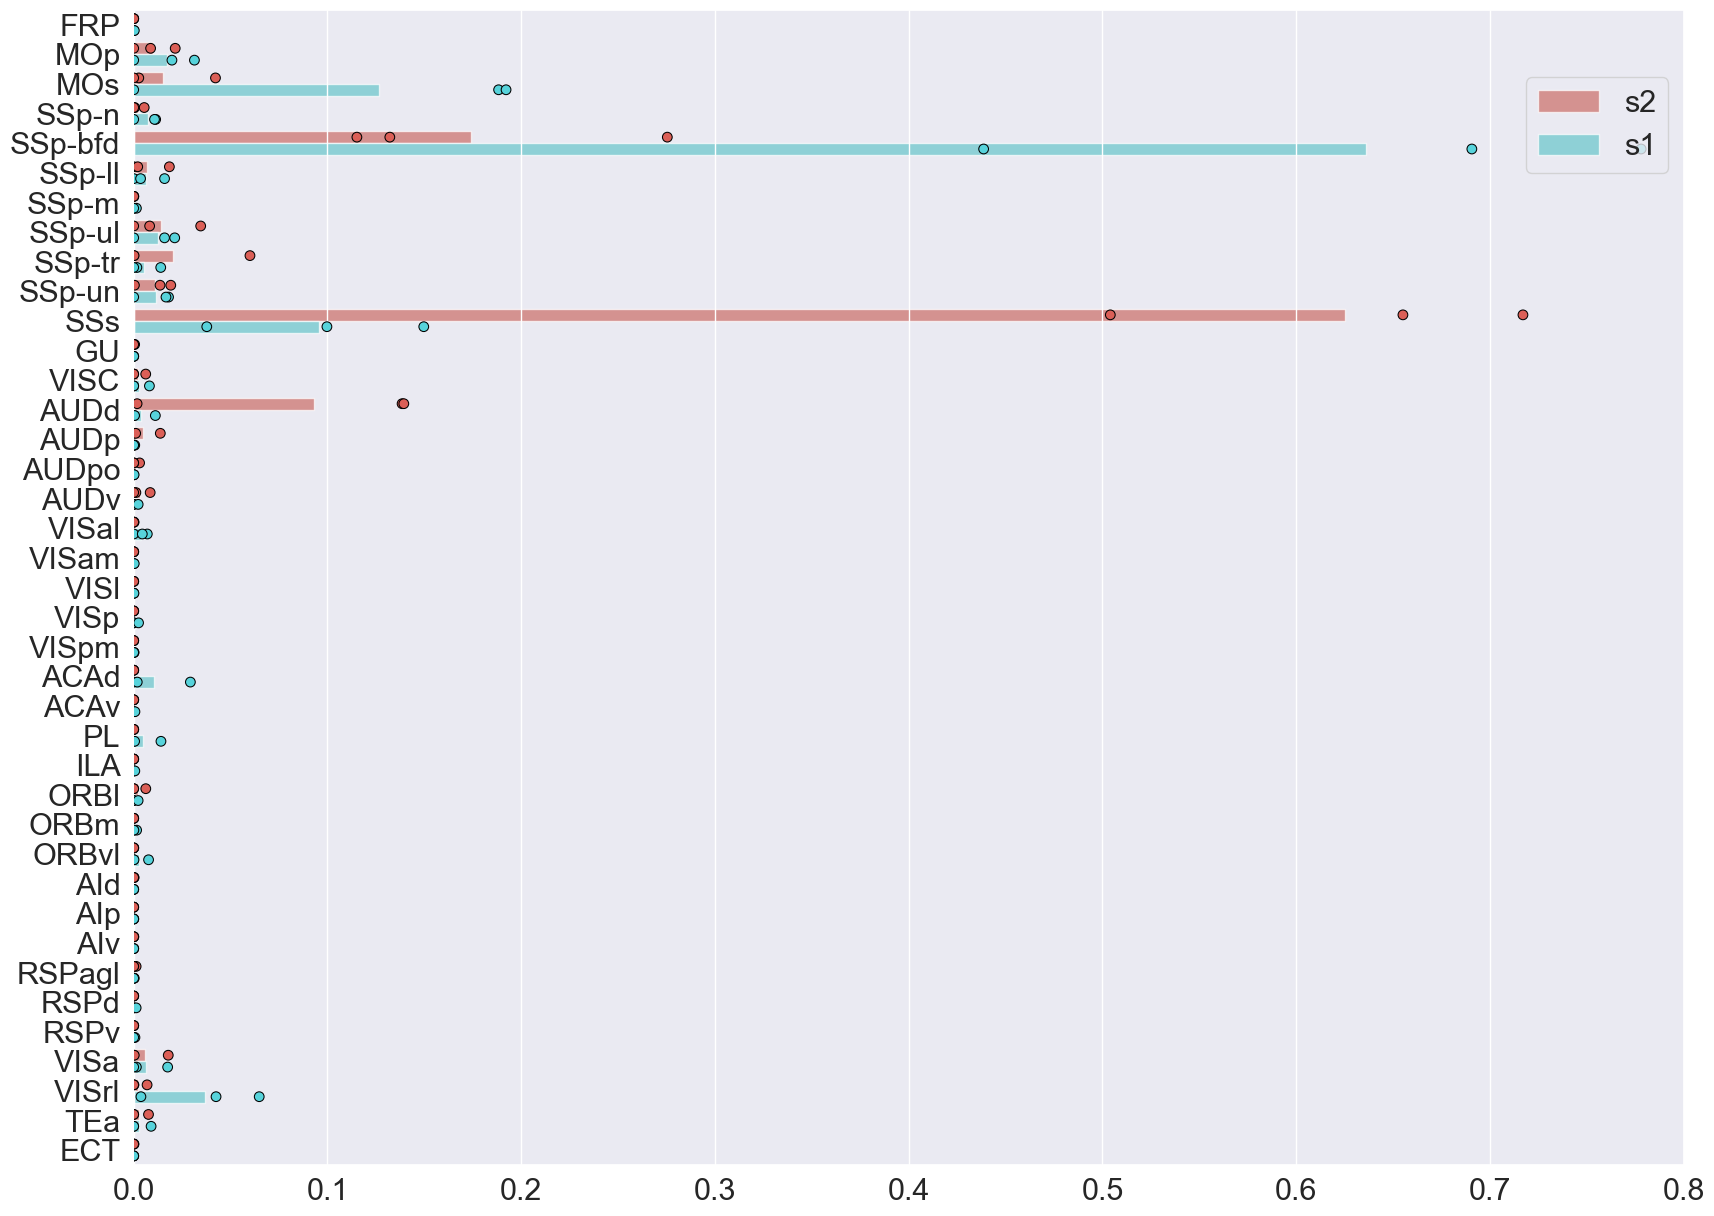

In [179]:
grouped_bar(expanded.sort_values(by='site',ascending=False),order,'left')

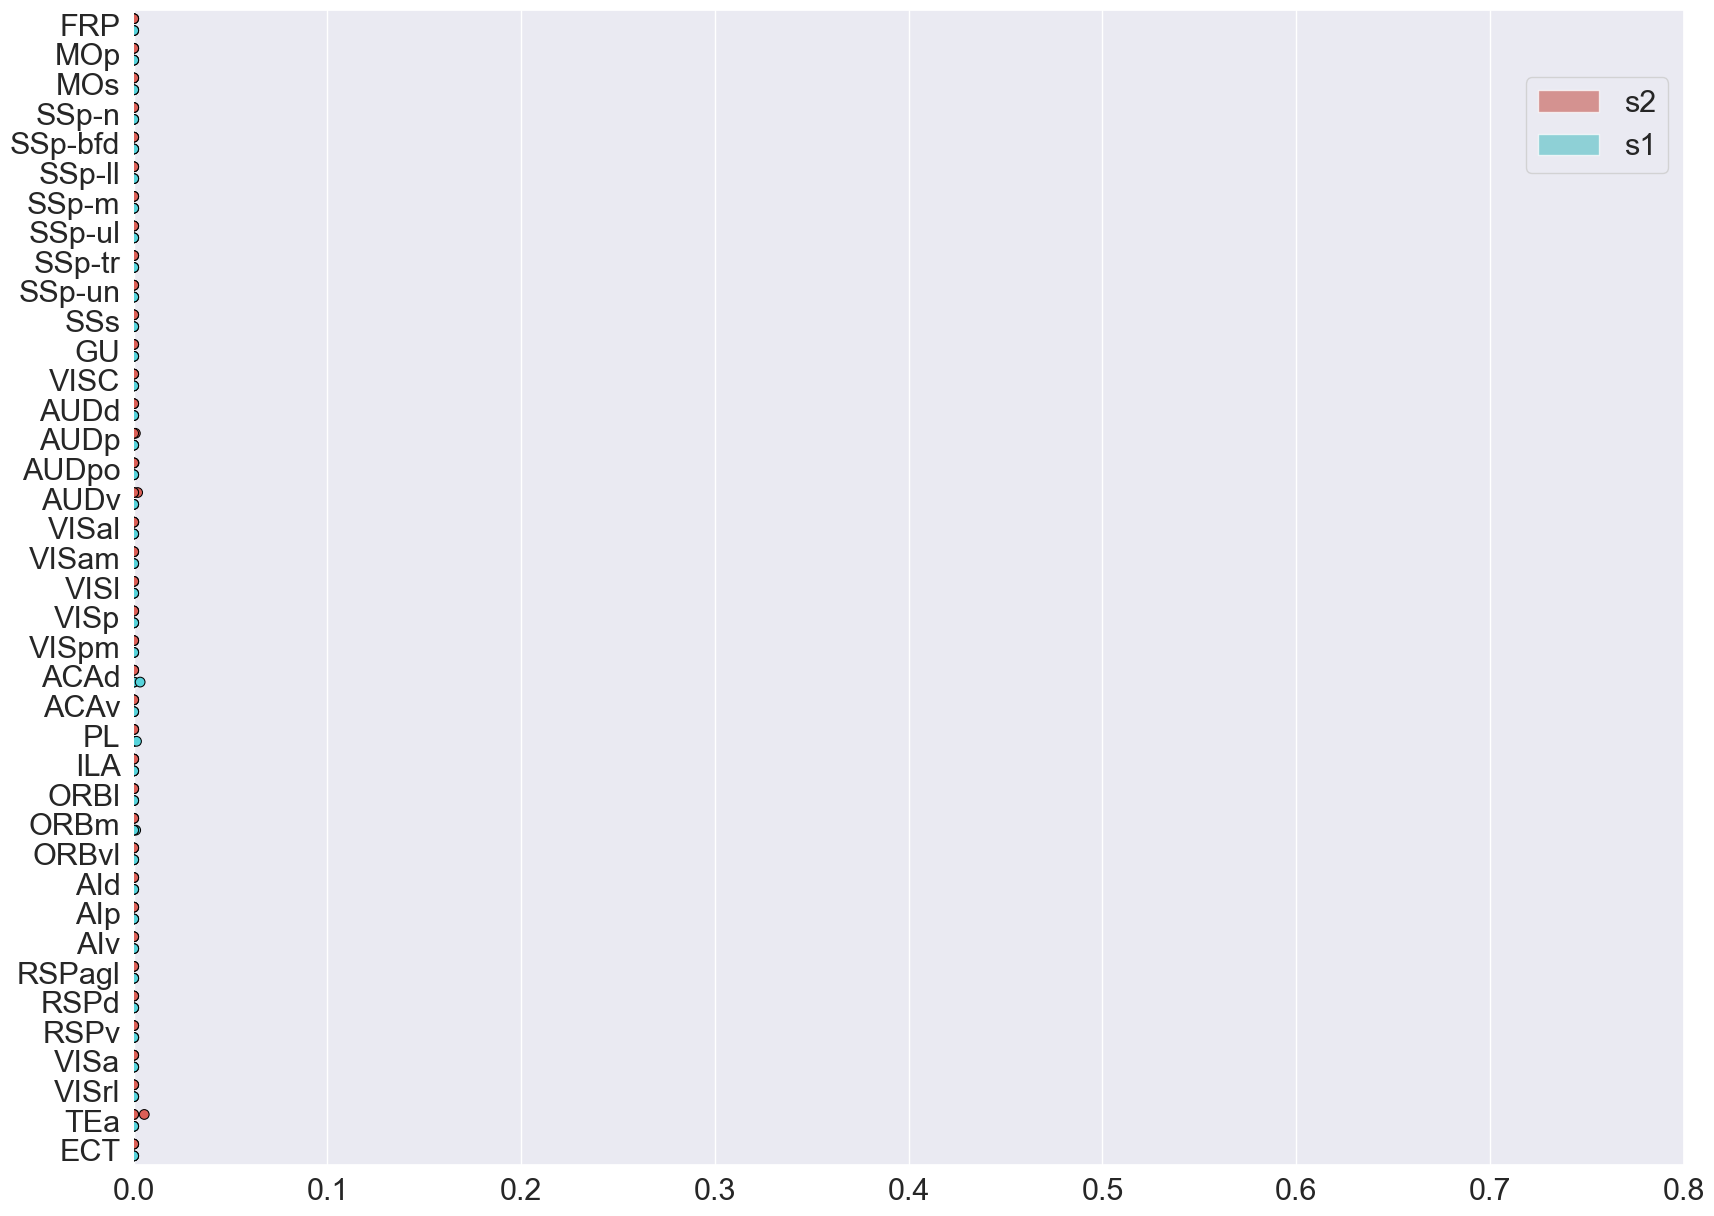

In [180]:
grouped_bar(expanded_r.sort_values(by='site',ascending=False),order,'right')

In [168]:
### test section for t test

both_df= pd.concat([s1_df, s2_df])
both_df=both_df.reset_index()
# combine the two df from s1 and s2 first

site_column= both_df.pop('site')
both_df.insert(1, "site", site_column, allow_duplicates=False)
# always make sure that the first column is index and secon column is injection site


In [169]:
from scipy.stats import ttest_ind

s1 = both_df[both_df['site']=='s1']
s2 = both_df[both_df['site']=='s2']

class1=pd.to_numeric(s1['MOs'])
class2=pd.to_numeric(s2['MOs'])

ttest_ind(class1, class2, equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

In [170]:
f=open(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.txt','w+')


for i in both_df.columns[2:]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= ttest_ind(class1, class2, equal_var=False)
        
    if pvalue< 0.05:
        print(f'{i}, p value = {pvalue}')
        f.write(f'{i}, p value = {pvalue} \n')
    else:
        pass

f.close()
    

### section to plot bar graphs- a givne region for one injection site for all lines

Cannot just simply plot their value as fraction of total axons in the brain, need normalization

Combine two parent region (ie. MOs and MOp into MO id= 500): 

    ie. All layer in MO should add up to one
    

WORK IN PROGRESS

Alternatively, normalize each layer to total amount of axon within the region ( ie, layers 1 to 6 within SSp-bfd adds up to 1)

strategy- loop through every name with a number would indicate a region 's layer, go to one depth up, find the atlas id

then unique this list to get all the region that have layer loop through this list to sum up its sublayers, divide all the layer within with this um

July 2023 update: 
    
    read six excel files less stupidly (using loop now) and everything is much more cleaner!
    


In [22]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def normalize_layers (df, samples_list):
    ''' useful for later maybe 
    not in the case of combing two motor regions though'''
    sum_parent=df.groupby(['parent_structure_id'],as_index=False).sum()
    # compute sum of the parent regions
    
    parent_df= sum_parent[samples_list]
    parent_df['id']= sum_parent['parent_structure_id']
    # store the sums for each corresponding sample and their parent id
    
    normalized_df=[]

    for i in parent_df.id:
        this_parent= parent_df[parent_df['id']==i]
        # find the corresponding denominator

        this_child= df[df['parent_structure_id']== i]
        #find the corresponding numerators

        fraction_df= this_child/ this_parent.iloc[0]
        # this_parent.iloc[0] for format conversion to series so we could devide
        this_fraction= fraction_df[samples_list]
        this_fraction['id']=this_child['id']

        normalized_df.append(this_fraction)

    # append separate df into list
    normalized_df=pd.concat(normalized_df)
    # concatenate the separate dfs, actually a briliiant way
    
    normalized_df_fullinfo= pd.merge(normalized_df,atlas_labels, on='id')
    #merge back with atlas labels to get full info
    
    return normalized_df_fullinfo

def norm_region(df, df_r, sample_list):
    
    ''' Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to'''
    
    region_sum= df.sum()[sample_list]
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()[sample_list]
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df[sample_list]/all_isocortex
    # divide left side to normalize
    df[sample_list]= norm_values

    norm_values_r= df_r[sample_list]/all_isocortex
    # divide right side to normalize
    df_r[sample_list]= norm_values_r

    return df, df_r

def sum_same_layer (df, layers_dict,sample_list):
    
    ''' Combine values from the same layer together, ie. MOs 2/3 and MOp 2/3
    need to give a dictionary! such as, {'MO1':'1','MO2/3':'2/3'}, note that the key must be EXACTLY matching atlas label acronym for later merge
    and the value is used to string.contain inside th acronym
    '''
    layers=[]

    for key, value in layers_dict.items():
        this_layer= df[df['acronym'].str.contains(f'{value}', case=False)].sum()
        # sum up this specific layer for MOs and MOp

        this_df= this_layer[sample_list]
        this_df['acronym'] = key
        # keep only acronym and sample values, to be merged to atlas labels later

        layers.append(this_df)
    
    return pd.DataFrame(layers)

def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (bigdf):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat(bigdf)
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df,order,region_id,injection,side):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)
    
    color= [sns.hls_palette()[0],sns.hls_palette()[3]] 
    # specify the color template so that  s1 is always hls palette 3 (a cyan like color) and s2 is always hls palette 0 (a reddish color)
    # here we indicate s2 first because usually the bar graphs show s2 first (data frame sort_values by site, ascending=False)

    fig, ax = plt.subplots(figsize=(10,10))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        order=order,
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        order=order,
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    ax.set(xlim=(0, 1))
    # do not change this xlim for this plot

    plt.savefig(f'{outdir}\\{injection}_{side}_normalized_{region_id}.svg')

    plt.show()
    

In [24]:

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

# change the following section(s) if required 
region='s1'

region_id='500'
layers_dict= {'MO1':'1','MO2/3':'2/3', 'MO5': '5', 'MO6a': '6a', 'MO6b': '6b'}
# note that the key must be EXACTLY matching atlas label acronym for later merge and the value is used to string.contain inside th acronym


MO_regions= atlas_labels.loc[atlas_labels['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
# find all the MO regions from the atlas labels
MO_regions= MO_regions[MO_regions.depth==MO_regions.depth.max()]
# exclude  useless one such as somatomotor areas itself (id=500) and other crap by taking only the max depth, usually these are the actual regions present in the atlas

all_MO_regions= atlas_labels.loc[atlas_labels['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
# ie. all regions containing this region id



In [25]:
cre_list=['ras', 'scn', 'tlx', 'rbp', 'sim', 'nts'] 

side='left'
huge_df= []
for i in cre_list:   

    file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{side}.xlsx'
    read_file= pd.read_excel(file_path)
    read_file=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    read_file['cre']=i
    
    huge_df.append(read_file)

In [26]:
side='right'
huge_df_r= []
for i in cre_list:   

    file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{side}.xlsx'
    read_file= pd.read_excel(file_path)
    read_file=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    read_file['cre']=i

    huge_df_r.append(read_file)


In [27]:
final_df=[]
final_df_r=[]

for i,value in enumerate(cre_list):
    # loop through individual dfs inside huge_df and hugd_df_r
    
    sample_list=find_sample_list(huge_df[i])
    # find sample list
    
    this_norm, this_norm_r= norm_region(huge_df[i], huge_df_r[i], sample_list)
    
    sample_list_temp=sample_list
    sample_list_temp.insert(0, 'acronym')

    # use this as a list of columns to extract from normalized regions so that we can merge to  the MO_regions from atlas labels
    # we do this because not all samples have all the motor layers, especially the right hemisphere!
    
    this_norm_full=MO_regions.merge(this_norm[sample_list_temp], on='acronym', how='outer')
    this_norm_full_r=MO_regions.merge(this_norm_r[sample_list_temp], on='acronym', how='outer')
    # merging is outer because some samples does not have all or any of the MO layers, but we sitll need to keep the region and assign zero
    
    this_sumlayer= sum_same_layer(this_norm_full,layers_dict, sample_list)
    this_sumlayer_r= sum_same_layer(this_norm_full_r,layers_dict, sample_list)
    # calculate the summing of same layer for left and right side
    
    this_summed= all_MO_regions.merge(this_sumlayer, on='acronym', how='inner')
    this_summed_r= all_MO_regions.merge(this_sumlayer_r, on='acronym', how='inner')
    #merge with atlas labels, we are doing this becauswe we need to later sort with graph order!!
    # merging is inner now because by definition they all acronym contained in summlayer df must be inside atlas label
    
    keep_df= extract_df(sample_list, this_summed,value)
    keep_df_r= extract_df(sample_list, this_summed_r,value)
    
    final_df.append(keep_df)
    final_df_r.append(keep_df_r)


In [28]:
expanded= combine_expanddf(final_df)
expanded_r= combine_expanddf(final_df_r)

In [29]:
order=final_df[0].columns.sort_values()[:-1]
# define order of bar graphs from 1 to 6b

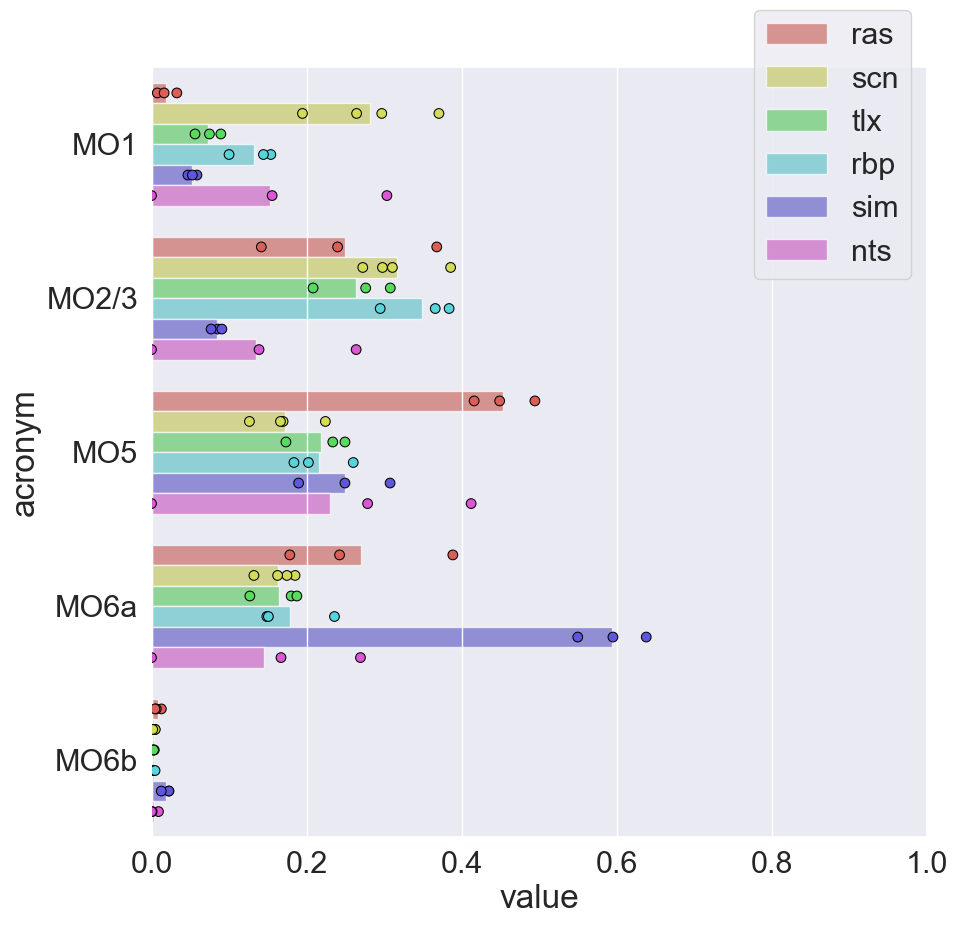

In [32]:
grouped_bar(expanded, order, region_id,region,'left')

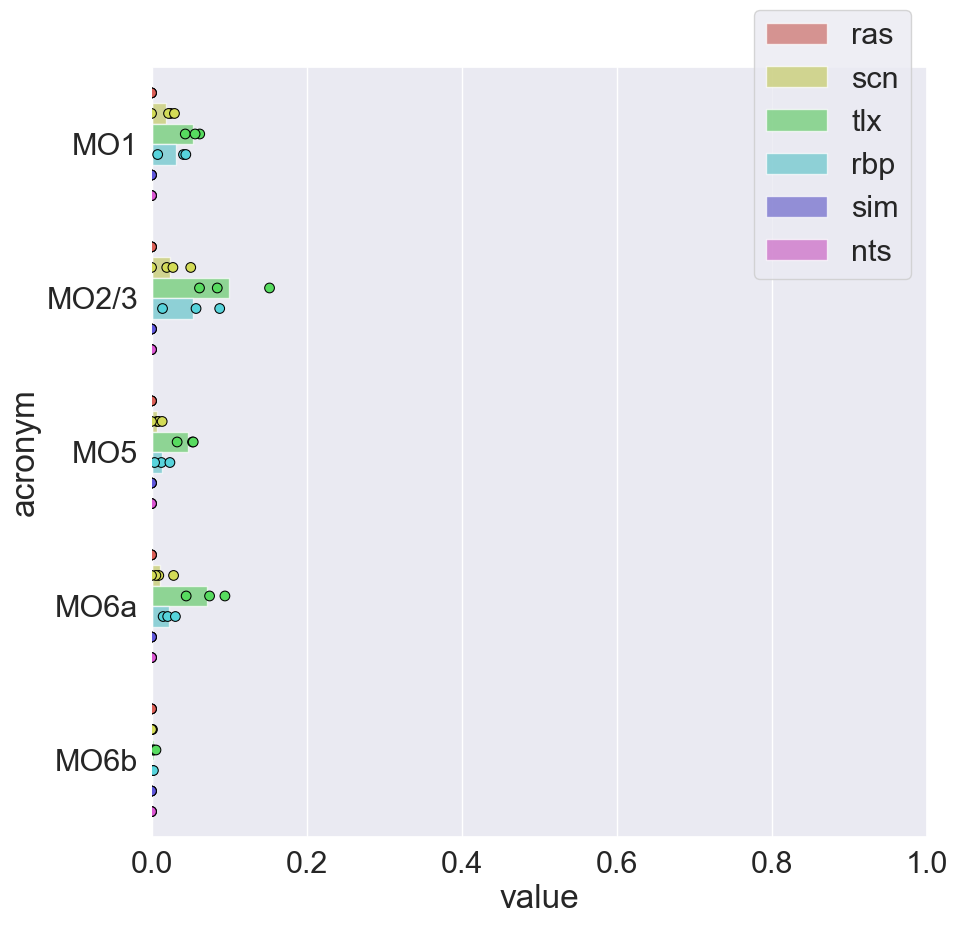

In [33]:
grouped_bar(expanded_r, order, region_id,region,'right')

### test region

[-0.17377256  1.56899161 -0.00825274  0.23547782]


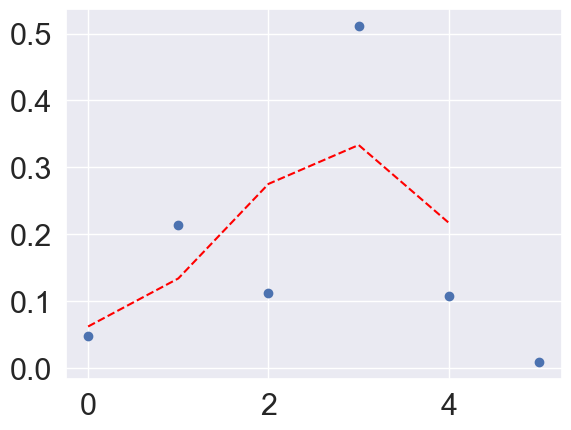

In [28]:
# curve fitting for layer distribution test

from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# define the true objective function
def objective(x, a, b, c, d):
 return a * sin(b - x) + c * x**2 + d
 
# load the dataset
x, y = cre1_norm.index, cre1_norm['AL254']

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d = popt
print(popt)
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

# OK not so good, since only have 6 data points (6 layers)

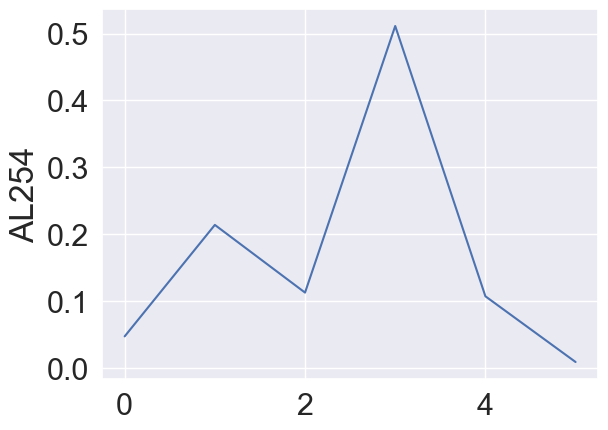

In [29]:
x, y = cre1_norm.index, cre1_norm['AL254']

sns.lineplot( x=x, y=y)   
plt.show()

### test section for hierarchical clustering

In [31]:
#final_df=final_df.rename(columns={'AL254': "ras1", 'AL255': "ras2", 'AL257': "ras3",
                         'AL290': "scn1", 'AL291': "scn2", 'AL292': "scn3",'AL293': "scn4",
                         'AL213': "tlx1", 'AL313': "tlx2", 'AL314': "tlx3",
                         'AL211': "rbp1", 'AL215': "rbp1", 'AL318': "rbp1",
                         'AL207': "sim1", 'AL209': "sim2", 'AL273': "sim3",
                         'AL274': "nts1", 'AL285': "nts2", 'AL311': "nts3",
                        })

#rearrange columns for sns.clustermap since it always wants to arrange columns in a weird way


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


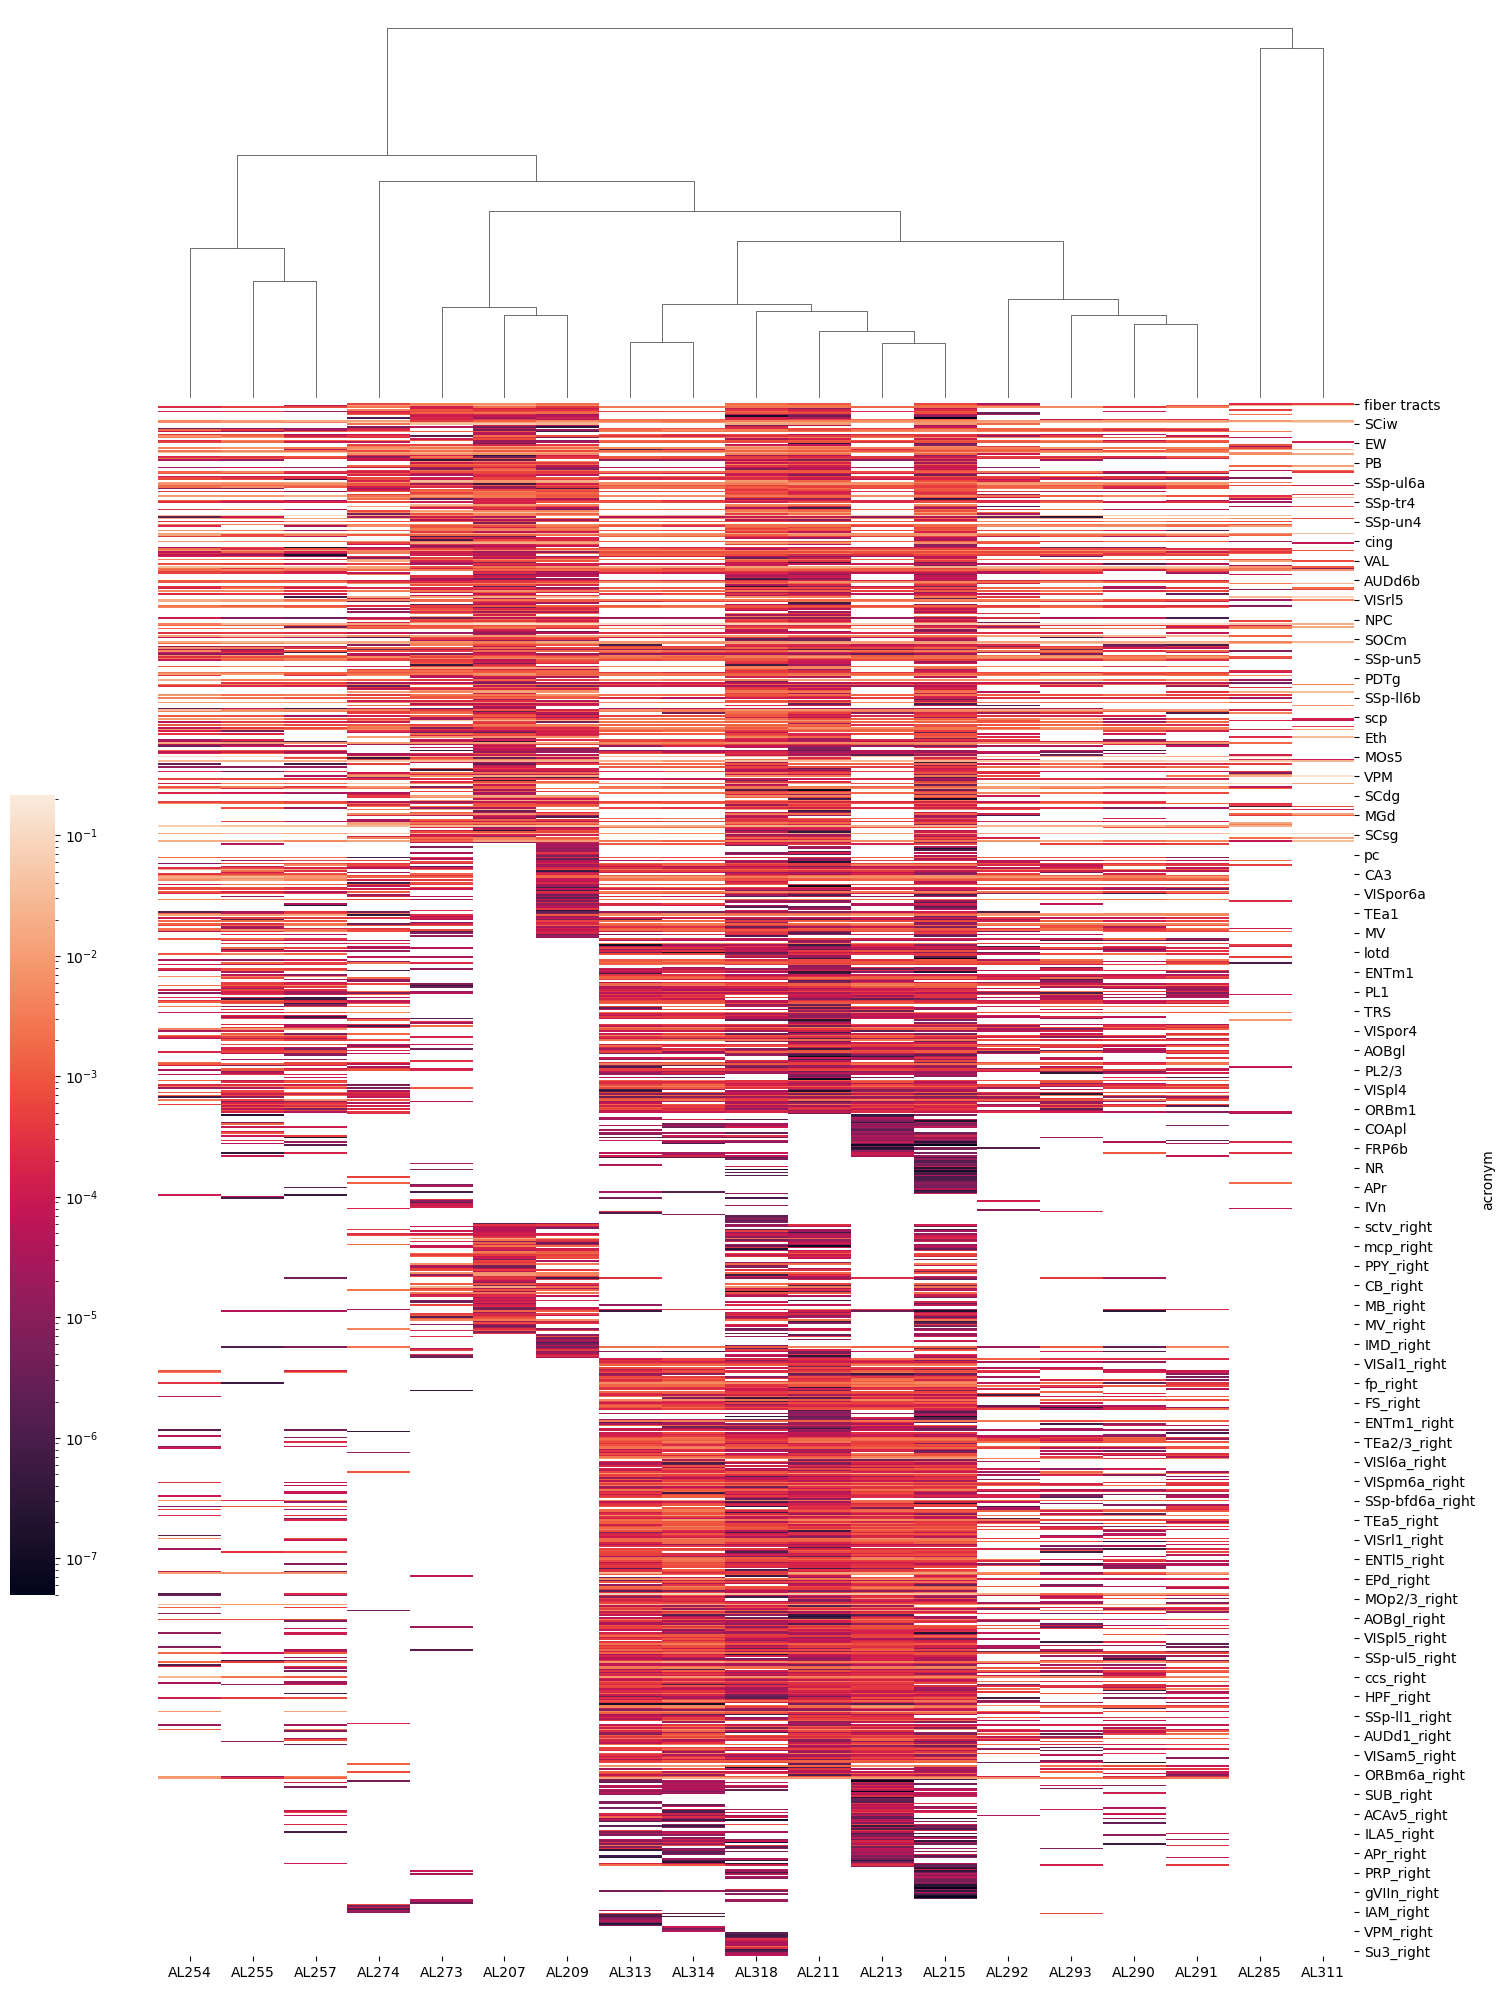

In [12]:
sns.clustermap(
    full_df,
    figsize=(15, 20),
    norm=LogNorm(),
    row_cluster=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4)
)

WORK IN PROGRESS
# still in a weird way after rearrangement,...need to look up